# analyze 30 s data sets

### Load and analyze the 30s loads data with ggplot

In [2]:
## Include into analysis consideration of which controller is running

In [174]:
# %matplotlib inline
import os
import computeDEL
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import scipy.io as spio
import wrapFunctions #import wrap180, wrap360, wrapList
import glob
import pandas as pd
from ggplot import *
import seaborn as sns
from scipy import stats

## Parameters

In [204]:
dataFolder = 'data30'
dataFolder = 'data30_redo'
dataFile  = os.path.join(dataFolder,'dataFileTemp.csv')

figFolder = 'signalPlots_ByControl'
maxminFolder = 'maxminPlots_ByControl'

lowTurb = False # Limit by TI?
tiLim = 6. # % TI to limit to 

In [205]:
# Definite a 95 % confidence interval function
def ci(x):
    return 1.64 * np.std(x) / np.sqrt(len(x))

## Load the data file

In [206]:
df = pd.read_csv(dataFile)

## Analysis

In [207]:
# Make output folder
if not os.path.exists(figFolder):
    os.makedirs(figFolder)
if not os.path.exists(maxminFolder):
    os.makedirs(maxminFolder)

In [208]:
# Add a channel which is cut wind speed and direction
binEdge = np.arange(3.,20.)
binEdge = np.arange(3.,16.)
df['windRange'] = pd.cut(df.WS1_90m_mean,binEdge,right=True)


binEdge = np.arange(3.5,16.5)
binLabel = np.arange(4.,16.)
df['windBin'] = pd.cut(df.WS1_90m_mean,binEdge,right=True,labels=binLabel)

binEdge = np.arange(-45.,55.,5) - 2.5
binLabel = range(-45,50,5)
#df['dirBin'] = pd.cut(df.apparantVane_mean,binEdge,right=True,labels=binLabel)
df['dirBin'] = pd.cut(df.WD_Nacelle_mean - 180.,binEdge,right=True,labels=binLabel)

In [209]:
# Limit by TI if told to:
if lowTurb:
    df['TI'] = 100. * df.WS1_90m_std / df.WS1_90m_mean
    df = df[df.TI < tiLim]
    df = df.drop('TI',axis=1)

In [210]:
# Set the style
sns.set_style("ticks",{"axes;grid": True})

In [211]:
# Grab a sigList
sigList = df.columns[:-2]

In [212]:
# Limit the sigList to a smaller set of interesting values
sigList = ['OPC_In_RotorSpd_mean',
'BL1_FlapMom_mean',
'TowerBaseTorque_mean',
'TB_ForeAft_mean',
'WS1_90m_mean',
'LSSDW_Mz_mean',
'LSSDW_My_mean',
'WindSpeed_80m_mean',
'TTTq_mean',
'TT_ForeAft_mean',
'Pitch_Blade1_mean',
'LSSDW_Tq_mean',
'TT_SideSide_mean',
'ApparentPower_mean',
'WD_Nacelle_mean',
'BL1_EdgeMom_mean',
'Mainshaft_Downwind_Torque_mean',
'LidarOffset_mean',
'Mainshaft_Downwind_Bend_90_mean',
'TowerTopTorque_mean',
'WD1_87m_mean',
'TBTq_mean',
'TB_SideSide_mean',
'OPC_In_RotorSpd_std',
'BL1_FlapMom_std',
'BL1_FlapMom_del',
'TowerBaseTorque_del',
'TB_ForeAft_del',
'WS1_90m_del',
'LSSDW_Mz_del',
'LSSDW_My_del',
'TTTq_del',
'TT_ForeAft_del',
'LSSDW_Tq_del',
'TT_SideSide_del',
'BL1_EdgeMom_del',
'Mainshaft_Downwind_Torque_del',
'Mainshaft_Downwind_Bend_90_del',
'TowerTopTorque_del',
'WD1_87m_del',
'TBTq_del',
'TB_SideSide_del']

## Determine the controllers and make some analysis

In [213]:
# Work off a copy for now
dfCont = df.copy()

In [214]:
# Make a quick plot of LidarOffset over time
fig, ax = plt.subplots()
ax.plot(dfCont.LidarOffset_mean)
plt.show()
#ax.set_xlim([12300,12350])

In [215]:
# Make a quick cut, wherever Lidar offset is changed from the previous, drop it
mask = np.zeros_like(dfCont.LidarOffset_mean,dtype=bool)
for i in range(len(dfCont.LidarOffset_mean)):
    if i > 0 :
        if (  abs(dfCont.LidarOffset_mean[i] - dfCont.LidarOffset_mean[i-1]) < 1.5):
            mask[i] = True

dfCont = dfCont[mask]   
dfCont = dfCont.reset_index()

In [216]:
# Name a controller column, rounded lidar
dfCont['yawControl'] = -1 * dfCont.LidarOffset_mean.round()

def fitControl(x):

    if ( abs (0.0 - x) < 1.0 ):
        return 0.0
    elif ( abs (12.5 - x) < 1.0 ):
        return 12.5
    elif ( abs (18.0 - x) < 1.0 ):
        return 18.0  
    elif ( abs (25.0 - x) < 1.0 ):
        return  25.0 
    elif ( abs (-25.0 - x) < 1.0 ):
        return  -25.0 
    else:
        return np.nan
dfCont['yawControl'] = dfCont.yawControl.apply(fitControl)

In [217]:
print dfCont.shape
dfCont = dfCont[dfCont.yawControl.notnull()]
print dfCont.shape
dfCont.yawControl.unique()

(35088, 141)
(35043, 141)


array([  0. ,  25. ,  12.5, -25. ])

In [218]:
# Convert yaw control to a string
dfCont['yawControl'] = dfCont.yawControl.astype(str)
#dfCont.yawControl.unique()

In [219]:
# Set up a color pallete for controls
controlList = [  '0.0' , '-25.0' , '12.5', '18.0' ,'25.0' ]
controlColorList = ['b','r','g','c','m']
newPal   = dict(zip(controlList, controlColorList))

In [220]:
# Lets see offsets by density

dfCont['offset'] = dfCont.WD_Nacelle_mean - 180.
g = sns.FacetGrid(dfCont, hue="yawControl",size=10,palette=newPal)#, ylim=(0, 10))
g.map(sns.distplot, "offset",hist=False )
g.ax.set_xlim([-45,45])
g.ax.legend()
g.ax.grid()
g.ax.axvline(-25,color='r')
g.ax.axvline(0,color='b')
g.ax.axvline(12.5,color='g')
g.ax.axvline(18,color='c')
g.ax.axvline(25,color='m')
g.savefig(os.path.join(figFolder,'__controlHist.png'),dpi=150)
plt.show()

## Single channel plots

In [221]:
# Collect statistics
dfGrouped = pd.groupby(dfCont,['dirBin','windRange','yawControl']).agg(['mean','std','count'])

In [222]:
# # Show available data
# #sig = 'BL1_FlapMom_mean' # just pick one
# dfStats = dfGrouped[sig].reset_index()

# g = sns.FacetGrid(dfStats, col="windRange",col_wrap=4, aspect=2)#, ylim=(0, 10))
# g.map(sns.barplot, "dirBin", "count")
# g.savefig(os.path.join(figFolder,'__histogram.png'),dpi=150)

In [223]:
#sigListDel = [s for s in sigList if '_del' in s]
#sigListMean = [s for s in sigList if '_mean' in s]
#sigListMeanDel = sigListDel + sigListMean

In [224]:
for sig in sigList:
    
    # Make the total folder
    totalFolder = os.path.join(figFolder,'total')
    if not os.path.exists(totalFolder):
        os.makedirs(totalFolder)
    
    if os.path.exists(os.path.join(totalFolder,sig + '.png')):
        print sig + '.png' + ' exists...'
        continue
    
    dfStats = dfGrouped[sig].reset_index()
    #dfStats = dfStats
    
    g = sns.FacetGrid(dfStats, col="windRange",hue="yawControl",col_wrap=4, aspect=2,palette=newPal)#, ylim=(0, 10))
    #g.map(plt.errorbar, "dirBin", "mean", "std", capsize=4)
    g.map(plt.plot, "dirBin", "mean",marker='s')
    #g.map(plt.scatter, "dirBin", "mean", 'count', color='k',alpha=0.5)
        
    for ax in g.axes.flat:
        ax.axvline(-25,color='r')
        ax.axvline(0,color='r')
        ax.axvline(25,color='r')
        ax.grid()
        ax.legend()
    g.savefig(os.path.join(totalFolder,sig + '.png'),dpi=150)

    plt.close('all')

OPC_In_RotorSpd_mean.png exists...
BL1_FlapMom_mean.png exists...
TowerBaseTorque_mean.png exists...
TB_ForeAft_mean.png exists...
WS1_90m_mean.png exists...
LSSDW_Mz_mean.png exists...
LSSDW_My_mean.png exists...
WindSpeed_80m_mean.png exists...
TTTq_mean.png exists...
TT_ForeAft_mean.png exists...
Pitch_Blade1_mean.png exists...
LSSDW_Tq_mean.png exists...
TT_SideSide_mean.png exists...
ApparentPower_mean.png exists...
WD_Nacelle_mean.png exists...
BL1_EdgeMom_mean.png exists...
Mainshaft_Downwind_Torque_mean.png exists...
LidarOffset_mean.png exists...
Mainshaft_Downwind_Bend_90_mean.png exists...
TowerTopTorque_mean.png exists...
WD1_87m_mean.png exists...
TBTq_mean.png exists...
TB_SideSide_mean.png exists...
OPC_In_RotorSpd_std.png exists...
BL1_FlapMom_std.png exists...
BL1_FlapMom_del.png exists...
TowerBaseTorque_del.png exists...
TB_ForeAft_del.png exists...
WS1_90m_del.png exists...
LSSDW_Mz_del.png exists...
LSSDW_My_del.png exists...
TTTq_del.png exists...
TT_ForeAft_del.p

## Redo via change by date

In [225]:
dfGrouped = pd.groupby(dfCont,['date','windBin','yawControl']).agg(['mean'])
dfGrouped = dfGrouped.applymap(abs)

# Run through the dates and wind speeds and subtract out baseline value
dateList = dfGrouped.index.levels[0].values

#dfGrouped.loc[date]

for date in dateList:
    print date
    windList = dfGrouped.loc[date].index.get_level_values('windBin').unique()
    for wind in windList:
        controlList = dfGrouped.loc[date,wind].index.values
        #print wind, controlList
        
        # If we don't have baseline, drop this row
        if '0.0' not in controlList:
            #print 'no baseline'
            dfGrouped.loc[date,wind] = np.nan
        
        # Otherwise go through and subtract the baseline
        else:
            base = dfGrouped.loc[date,wind,'0.0'].copy()
            for c in controlList:
                dfGrouped.loc[date,wind,c] = dfGrouped.loc[date,wind,c] - base
 


dfAvg = pd.groupby(dfGrouped.reset_index(),['windBin','yawControl']).agg(['mean','std','count',ci])

# Clean up columns
dfAvg.columns = dfAvg.columns.droplevel(1)


2016-08-03
2016-08-04
2016-08-05
2016-08-06
2016-08-07
2016-08-08
2016-08-09
2016-08-10
2016-08-11
2016-08-12
2016-08-13
2016-08-15
2016-08-16
2016-08-17
2016-08-18
2016-08-19
2016-08-20
2016-08-21
2016-08-22
2016-08-29
2016-08-30
2016-08-31
2016-09-01
2016-09-05
2016-09-06
2016-09-07
2016-09-08
2016-09-09
2016-09-10
2016-09-11
2016-09-12
2016-09-13
2016-09-14_a
2016-09-14_b
2016-09-15
2016-09-16
2016-09-17
2016-09-18
2016-09-19
2016-09-20
2016-09-22
2016-09-23
2016-09-24
2016-09-26
2016-10-08
2016-10-09
2016-10-10
2016-10-11
2016-10-12
2016-10-13
2016-10-14
2016-10-15
2016-10-16
2016-10-17
2016-10-18
2016-10-19
2016-10-20
2016-10-21
2016-10-22
2016-10-23
2016-10-24
2016-10-25
2016-10-26


In [226]:
# Now make the delta analysis plots
for sig in sigList:
    
    # Make the total folder
    deltaFolder = os.path.join(figFolder,'delta')
    if not os.path.exists(deltaFolder):
        os.makedirs(deltaFolder)
    
    if os.path.exists(os.path.join(deltaFolder,sig + '.png')):
        print sig + '.png' + ' exists...'
        continue
    
    dfStats = dfAvg[sig].reset_index()

    
    g = sns.FacetGrid(dfStats,hue="yawControl",palette=newPal,size=5)#, ylim=(0, 10))
    g.map(plt.errorbar, "windBin", "mean", "ci", capsize=4)
    #g.map(plt.plot, "windBin", "mean",marker='s')
    g.map(plt.scatter, "windBin", "mean", 'count', color='k',alpha=0.5)
        
    for ax in g.axes.flat:
        #ax.axvline(-25,color='r')
        #ax.axvline(0,color='r')
        #ax.axvline(25,color='r')
        ax.set_xlim([0,16])
        ax.grid()
        ax.legend()
    g.savefig(os.path.join(deltaFolder,sig + '.png'),dpi=150)

    plt.close('all')

OPC_In_RotorSpd_mean.png exists...
BL1_FlapMom_mean.png exists...
TowerBaseTorque_mean.png exists...
TB_ForeAft_mean.png exists...
WS1_90m_mean.png exists...
LSSDW_Mz_mean.png exists...
LSSDW_My_mean.png exists...
WindSpeed_80m_mean.png exists...
TTTq_mean.png exists...
TT_ForeAft_mean.png exists...
Pitch_Blade1_mean.png exists...
LSSDW_Tq_mean.png exists...
TT_SideSide_mean.png exists...
ApparentPower_mean.png exists...
WD_Nacelle_mean.png exists...
BL1_EdgeMom_mean.png exists...
Mainshaft_Downwind_Torque_mean.png exists...
LidarOffset_mean.png exists...
Mainshaft_Downwind_Bend_90_mean.png exists...
TowerTopTorque_mean.png exists...
WD1_87m_mean.png exists...
TBTq_mean.png exists...
TB_SideSide_mean.png exists...
OPC_In_RotorSpd_std.png exists...
BL1_FlapMom_std.png exists...
BL1_FlapMom_del.png exists...
TowerBaseTorque_del.png exists...
TB_ForeAft_del.png exists...
WS1_90m_del.png exists...
LSSDW_Mz_del.png exists...
LSSDW_My_del.png exists...
TTTq_del.png exists...
TT_ForeAft_del.p

## By Percent Change

In [227]:


dfGrouped = pd.groupby(dfCont,['date','windBin','yawControl']).agg(['mean'])
dfGrouped = dfGrouped.applymap(abs)



# Run through the dates and wind speeds and subtract out baseline value
dateList = dfGrouped.index.levels[0].values

#dfGrouped.loc[date]

for date in dateList:
    print date
    windList = dfGrouped.loc[date].index.get_level_values('windBin').unique()
    for wind in windList:
        controlList = dfGrouped.loc[date,wind].index.values
        #print wind, controlList
        
        # If we don't have baseline, drop this row
        if '0.0' not in controlList:
            #print 'no baseline'
            dfGrouped.loc[date,wind] = np.nan
        
        # Otherwise go through and subtract the baseline
        else:
            base = dfGrouped.loc[date,wind,'0.0'].copy()
            #if abs(base) > 0.0:
            for c in controlList:
                dfGrouped.loc[date,wind,c] = 100. * (dfGrouped.loc[date,wind,c] - base)/base

#np.c
dfAvg = pd.groupby(dfGrouped.reset_index(),['windBin','yawControl']).agg(['mean','std','count',ci])

# Clean up columns
dfAvg.columns = dfAvg.columns.droplevel(1)
dfAvg

2016-08-03
2016-08-04
2016-08-05
2016-08-06
2016-08-07
2016-08-08
2016-08-09
2016-08-10
2016-08-11
2016-08-12
2016-08-13
2016-08-15
2016-08-16
2016-08-17
2016-08-18
2016-08-19
2016-08-20
2016-08-21
2016-08-22
2016-08-29
2016-08-30
2016-08-31
2016-09-01
2016-09-05
2016-09-06
2016-09-07
2016-09-08
2016-09-09
2016-09-10
2016-09-11
2016-09-12
2016-09-13
2016-09-14_a
2016-09-14_b
2016-09-15
2016-09-16
2016-09-17
2016-09-18
2016-09-19
2016-09-20
2016-09-22
2016-09-23
2016-09-24
2016-09-26
2016-10-08
2016-10-09
2016-10-10
2016-10-11
2016-10-12
2016-10-13
2016-10-14
2016-10-15
2016-10-16
2016-10-17
2016-10-18
2016-10-19
2016-10-20
2016-10-21
2016-10-22
2016-10-23
2016-10-24
2016-10-25
2016-10-26


index                            OPC_In_RotorSpd_mean  \
                        mean        std count        ci                 mean   
windBin yawControl                                                             
4.0     -25.0      -0.082756   0.760450     6  0.464781             0.065515   
        0.0         0.000000   0.000000    57  0.000000             0.000000   
        12.5       -0.022131   1.431695     9  0.737899            -0.111225   
        25.0        0.055310   1.882717    49  0.423789             0.104098   
5.0     -25.0       0.471930   0.848826     7  0.487124            -2.217544   
        0.0         0.000000   0.000000    60  0.000000             0.000000   
        12.5        0.226800   0.888790    10  0.437285             0.645992   
        25.0        2.929921  16.757105    56  3.545718            -0.935705   
6.0     -25.0       1.143929   1.168139     7  0.670372             2.905988   
        0.0         0.000000   0.000000    56  0.000000             0.000000   
        12.5        0.119927   0.649273     9  0.334637            -2.291179   
        25.0        1.608147   8.858876    53  1.940461            -3.326469   
7.0     -25.0       0.788835   0.794765     6  0.485754            -4.749765   
        0.0         0.000000   0.000000    51  0.000000             0.000000   
        12.5       -0.292166   0.916057     9  0.472138             0.476139   
        25.0        0.246110   1.887073    45  0.446379            -5.659577   
8.0     -25.0       0.466923   0.667468     5  0.399709            -4.705174   
        0.0         0.000000   0.000000    46  0.000000             0.000000   
        12.5       -0.122510   0.924977     8  0.501688             3.108867   
        25.0        0.545397   2.188182    42  0.540705            -3.550448   
9.0     -25.0       0.095417   0.651030     5  0.427075            -0.916260   
        0.0         0.000000   0.000000    42  0.000000             0.000000   
        12.5       -0.069842   0.967858     8  0.524946             0.423840   
        25.0        0.255097   2.475859    38  0.649961            -2.520125   
10.0    -25.0       0.035583   0.627024     5  0.411328            -0.992428   
        0.0         0.000000   0.000000    34  0.000000             0.000000   
        12.5       -0.119931   1.066507     7  0.572518             3.977498   
        25.0        0.284490   1.228135    32  0.335090             0.282923   
11.0    -25.0       0.102858   0.511192     5  0.335342            -0.430518   
        0.0         0.000000   0.000000    30  0.000000             0.000000   
        12.5       -0.214257   1.011134     6  0.572154            -1.042724   
        25.0       -0.342600   2.956579    29  0.829385            -0.282368   
12.0    -25.0       0.099677   0.578556     5  0.379533            -1.443330   
        0.0         0.000000   0.000000    25  0.000000             0.000000   
        12.5       -0.425418   0.894073     4  0.479953             0.071266   
        25.0        0.547744   1.423301    23  0.416800             0.778121   
13.0    -25.0       0.040919   0.355067     5  0.232924             0.009777   
        0.0         0.000000   0.000000    22  0.000000             0.000000   
        12.5       -0.086790   0.862504     3  0.471502             0.088267   
        25.0        0.175716   1.848370    19  0.590095             0.744495   
14.0    -25.0       0.114184   0.583151     4  0.414120             0.013070   
        0.0         0.000000   0.000000    19  0.000000             0.000000   
        12.5       -0.606345   0.746008     3  0.407818            -0.160367   
        25.0        0.494673   2.299281    15  0.794959             3.079807   
15.0    -25.0      -0.459491   0.967854     3  0.648005             0.007337   
        0.0         0.000000   0.000000    17  0.000000             0.000000   
        12.5       -0.763334   0.158446     2  0.106084             1.366577   
        25.0        0.1

In [228]:
# Now make the pchange analysis plots
for sig in sigList:
    
    # Make the total folder
    pChangeFolder = os.path.join(figFolder,'pChange')
    if not os.path.exists(pChangeFolder):
        os.makedirs(pChangeFolder)
    
    if os.path.exists(os.path.join(pChangeFolder,sig + '.png')):
        print sig + '.png' + ' exists...'
        continue
    
    dfStats = dfAvg[sig].reset_index()

    
    g = sns.FacetGrid(dfStats,hue="yawControl",palette=newPal,size=5)#, ylim=(0, 10))
    g.map(plt.errorbar, "windBin", "mean", "ci", capsize=4)
    #g.map(plt.plot, "windBin", "mean",marker='s')
    g.map(plt.scatter, "windBin", "mean", 'count',alpha=0.5)
        
    for ax in g.axes.flat:
        #ax.axvline(-25,color='r')
        #ax.axvline(0,color='r')
        #ax.axvline(25,color='r')
        ax.set_xlim([0,16])
        ax.grid()
        ax.legend()
        ax.set_ylim([-150,150])
    g.savefig(os.path.join(pChangeFolder,sig + '.png'),dpi=150)

    plt.close('all')

## Redo by date

In [28]:
# Grab the dates
dateList = sorted(dfCont.date.unique())
dateList

['2016-08-03',
 '2016-08-04',
 '2016-08-05',
 '2016-08-06',
 '2016-08-07',
 '2016-08-08',
 '2016-08-09']

In [49]:
# For each data
for date in dateList:
    print 'Processing date ' + date
    
    # Make the folder if needed
    dateFolder = os.path.join(figFolder,date)
    if not os.path.exists(dateFolder):
        os.makedirs(dateFolder)
        
    # Limit data frame to this date
    dfLim = dfCont[dfCont.date==date]
    
    ## SPLIT ANALYSIS
    
    # Collect statistics
    dfGrouped = pd.groupby(dfLim,['dirBin','windRange','yawControl']).agg(['mean','std','count'])
    
    # Make the split folder
    splitFolder = os.path.join(dateFolder,'split')
    if not os.path.exists(splitFolder):
        os.makedirs(splitFolder)
        
    # Do the split analysis
    for sig in sigList:
    
        if os.path.exists(os.path.join(splitFolder,sig + '.png')):
            print sig + '.png' + ' exists...'
            continue

        dfStats = dfGrouped[sig].reset_index()
        #dfStats = dfStats

        g = sns.FacetGrid(dfStats, col="windRange",hue="yawControl",col_wrap=4, aspect=2,palette=newPal)#, ylim=(0, 10))
        #g.map(plt.errorbar, "dirBin", "mean", "std", capsize=4)
        g.map(plt.plot, "dirBin", "mean",marker='s')
        #g.map(plt.scatter, "dirBin", "mean", 'count', color='k',alpha=0.5)

        for ax in g.axes.flat:
            ax.axvline(-25,color='r')
            ax.axvline(0,color='r')
            ax.axvline(25,color='r')
            ax.grid()
            ax.legend()
        g.savefig(os.path.join(splitFolder,sig + '.png'),dpi=150)
        
        plt.close('all')
        
    ## OVERALL ANALYSIS
    
    # Collect statistics
    dfGrouped = pd.groupby(dfLim,['windBin','yawControl']).agg(['mean','std','count'])
    
    # Make the split folder
    overallFolder = os.path.join(dateFolder,'overall')
    if not os.path.exists(overallFolder):
        os.makedirs(overallFolder)
        
    # Do the split analysis
    for sig in sigList:
    
        if os.path.exists(os.path.join(overallFolder,sig + '.png')):
            print sig + '.png' + ' exists...'
            continue

        dfStats = dfGrouped[sig].reset_index()
        #dfStats = dfStats

        g = sns.FacetGrid(dfStats,hue="yawControl",palette=newPal,size=5)#, ylim=(0, 10))
        #g.map(plt.errorbar, "dirBin", "mean", "std", capsize=4)
        g.map(plt.plot, "windBin", "mean",marker='s')
        #g.map(plt.scatter, "dirBin", "mean", 'count', color='k',alpha=0.5)

        for ax in g.axes.flat:
            #ax.axvline(-25,color='r')
            #ax.axvline(0,color='r')
            #ax.axvline(25,color='r')
            ax.set_xlim([0,16])
            ax.grid()
            ax.legend()
        g.savefig(os.path.join(overallFolder,sig + '.png'),dpi=150)        
        
        
        plt.close('all')
    

Processing date 2016-08-03
OPC_In_RotorSpd_mean.png exists...
BL1_FlapMom_mean.png exists...
TowerBaseTorque_mean.png exists...
TB_ForeAft_mean.png exists...
WS1_90m_mean.png exists...
LSSDW_Mz_mean.png exists...
LSSDW_My_mean.png exists...
WindSpeed_80m_mean.png exists...
TTTq_mean.png exists...
TT_ForeAft_mean.png exists...
Pitch_Blade1_mean.png exists...
LSSDW_Tq_mean.png exists...
TT_SideSide_mean.png exists...
ApparentPower_mean.png exists...
WD_Nacelle_mean.png exists...
BL1_EdgeMom_mean.png exists...
Mainshaft_Downwind_Torque_mean.png exists...
LidarOffset_mean.png exists...
Mainshaft_Downwind_Bend_90_mean.png exists...
TowerTopTorque_mean.png exists...
WD1_87m_mean.png exists...
TBTq_mean.png exists...
TB_SideSide_mean.png exists...
OPC_In_RotorSpd_std.png exists...
BL1_FlapMom_std.png exists...
BL1_FlapMom_del.png exists...
TowerBaseTorque_del.png exists...
TB_ForeAft_del.png exists...
WS1_90m_del.png exists...
LSSDW_Mz_del.png exists...
LSSDW_My_del.png exists...
TTTq_del.png

KeyboardInterrupt: 

## MAX MIN PLOT

In [12]:
## MAX MIN PLOT
# Try to plot at once the max, min mean of a signal

# First collect signal names
rootNames = [s.rpartition('_')[0] for s in sigList]
rootNames = list(set(rootNames))
print rootNames

['OPC_In_RotorSpd', 'WD_Nacelle', 'TT_SideSide', 'TowerBaseTorque', 'Yaw_Encoder', 'TB_ForeAft', 'LSSDW_Mz', 'LSSDW_My', 'TT_ForeAft', 'LSSDW_Tq', 'WS1_90m', 'Pitch_Blade1', 'BL1_FlapMom', 'TBTq', 'ApparentPower', 'apparantVane', 'BL1_EdgeMom', 'Mainshaft_Downwind_Torque', 'Azimuth', 'LidarOffset', 'LabVIEWTimestamp', 'Mainshaft_Downwind_Bend_90', 'TowerTopTorque', 'WD1_87m', 'TTTq', 'TB_SideSide']


In [13]:
#dfGrouped
#dataChannels = [ sig + '_min', sig + '_mean', sig + '_max']
#dfSub = dfGrouped[dataChannels].reset_index()
#dfSub.columns = [''.join(col).strip() for col in dfSub.columns.values]
#dfSub.columns = [c.replace(sig,'sig') for c in dfSub.columns]
#dfSub

RuntimeError: Could not allocate memory for image

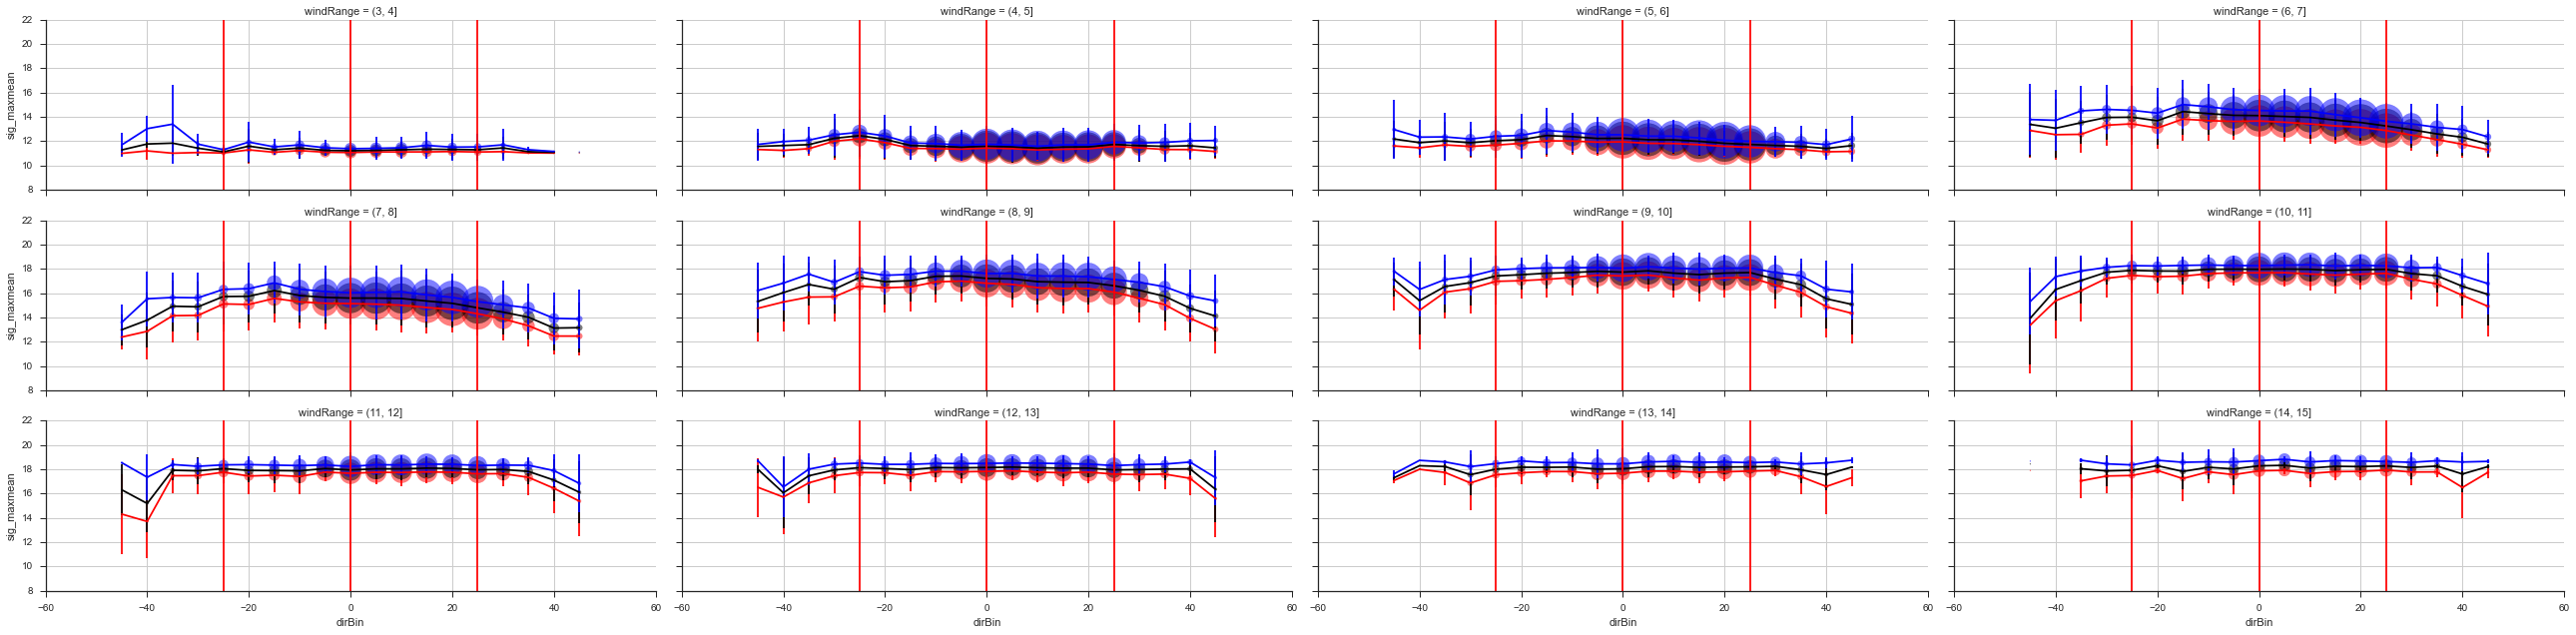

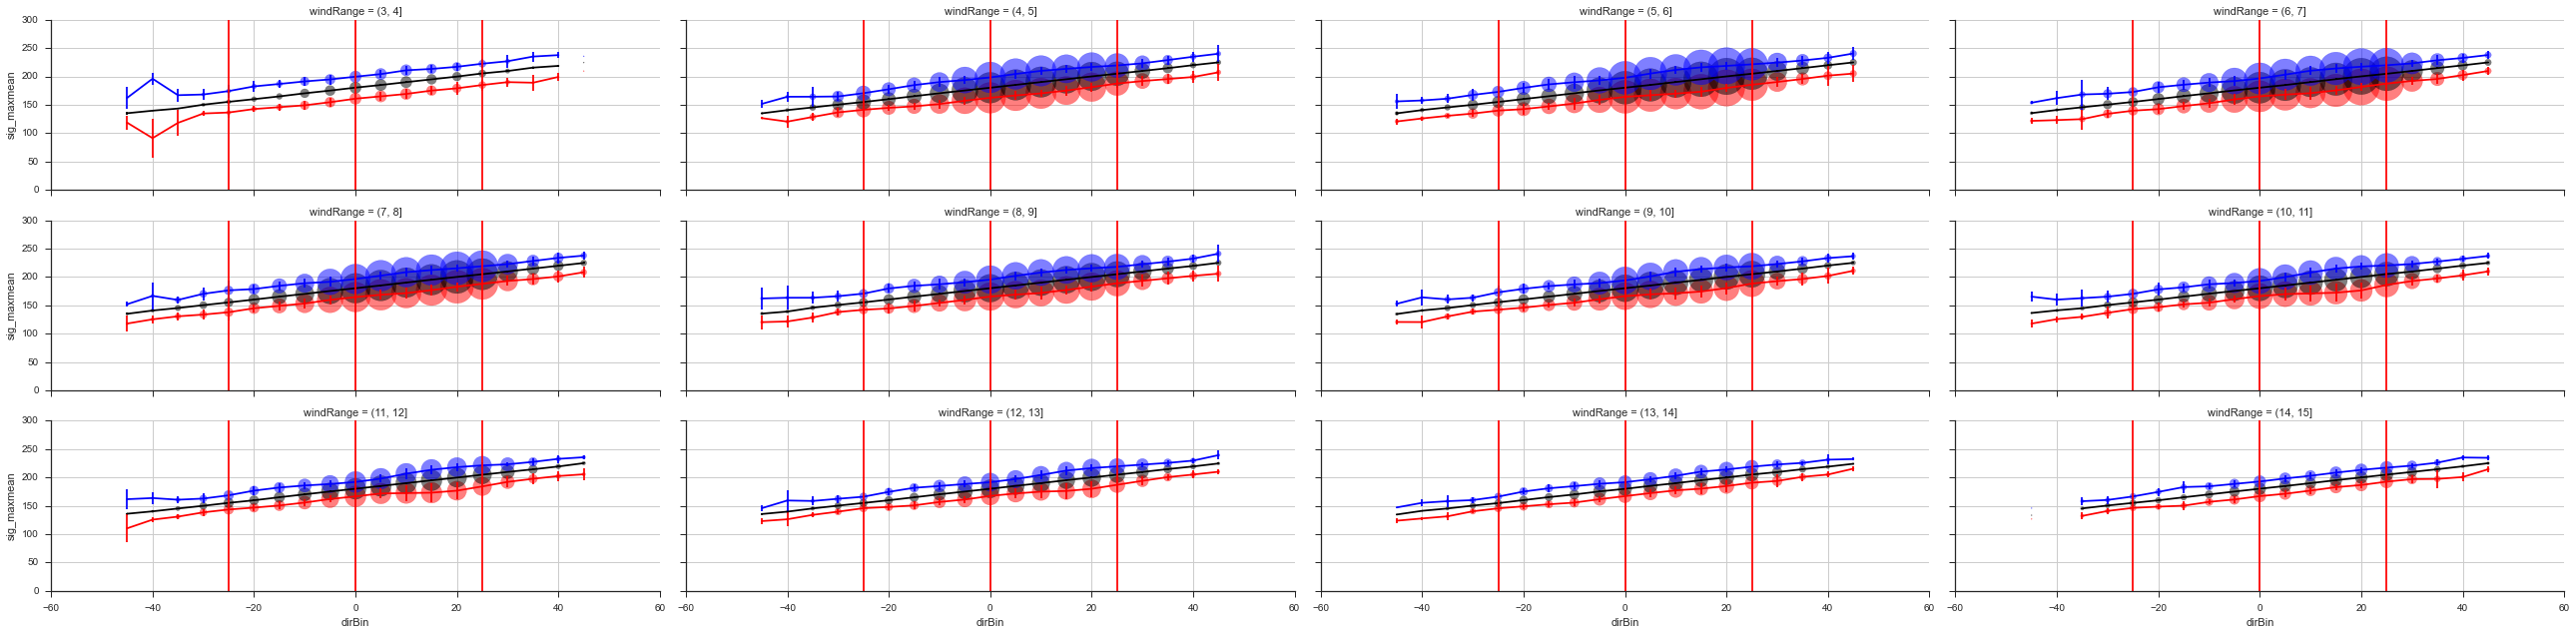

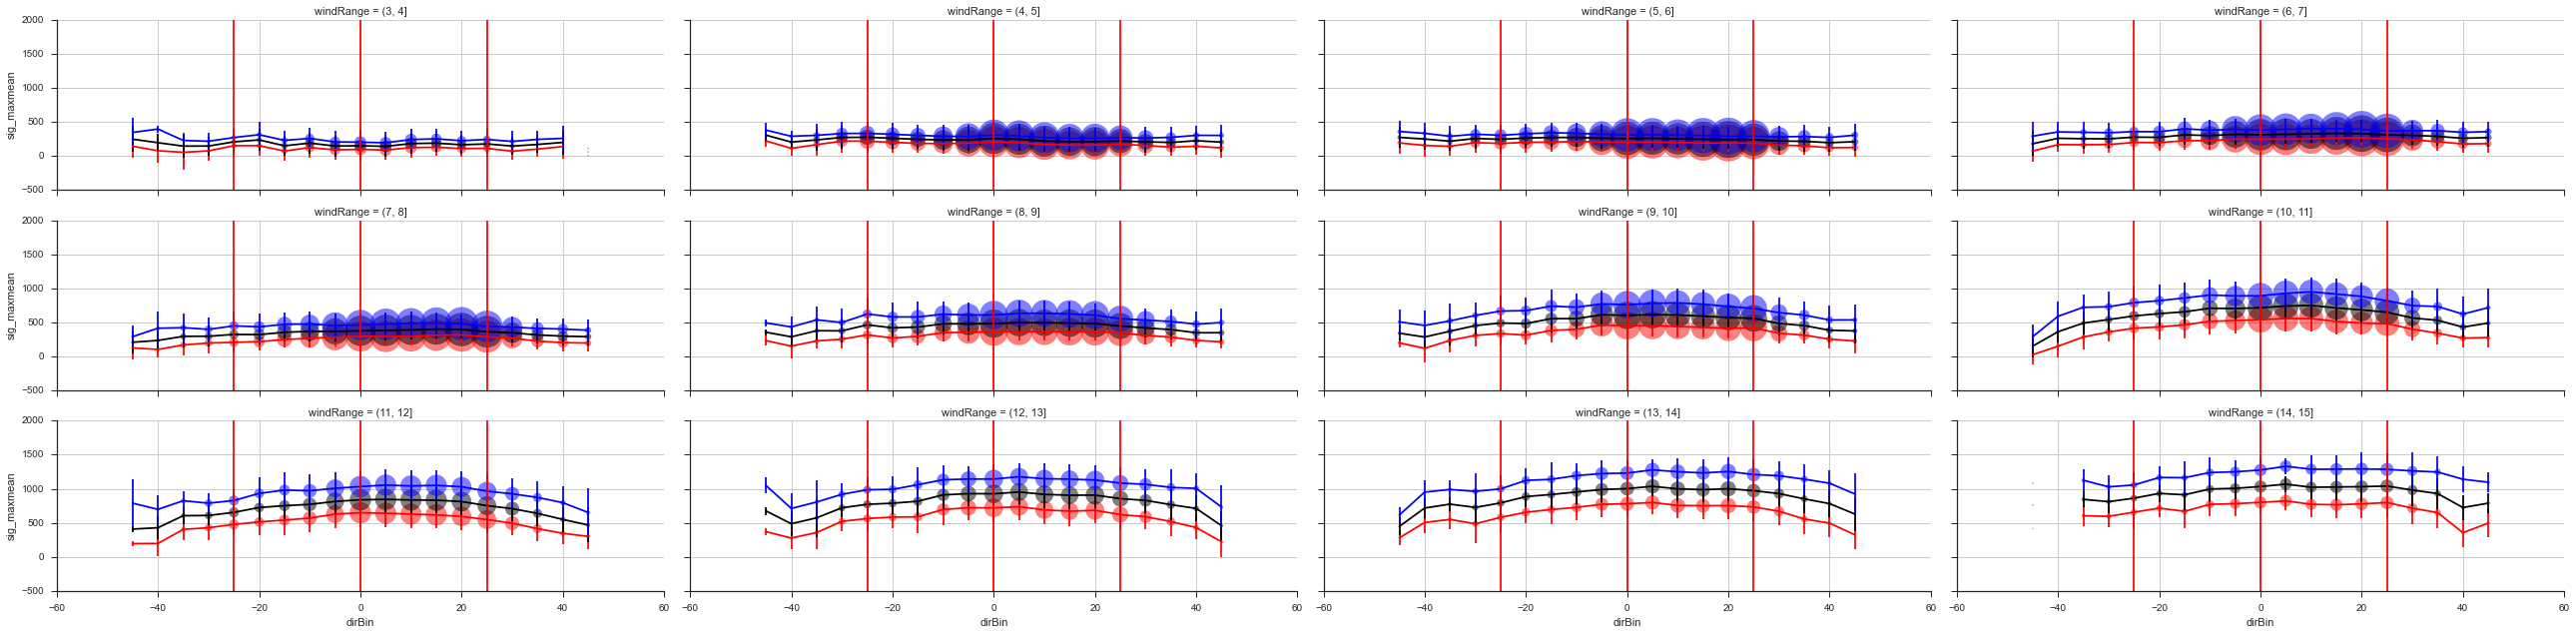

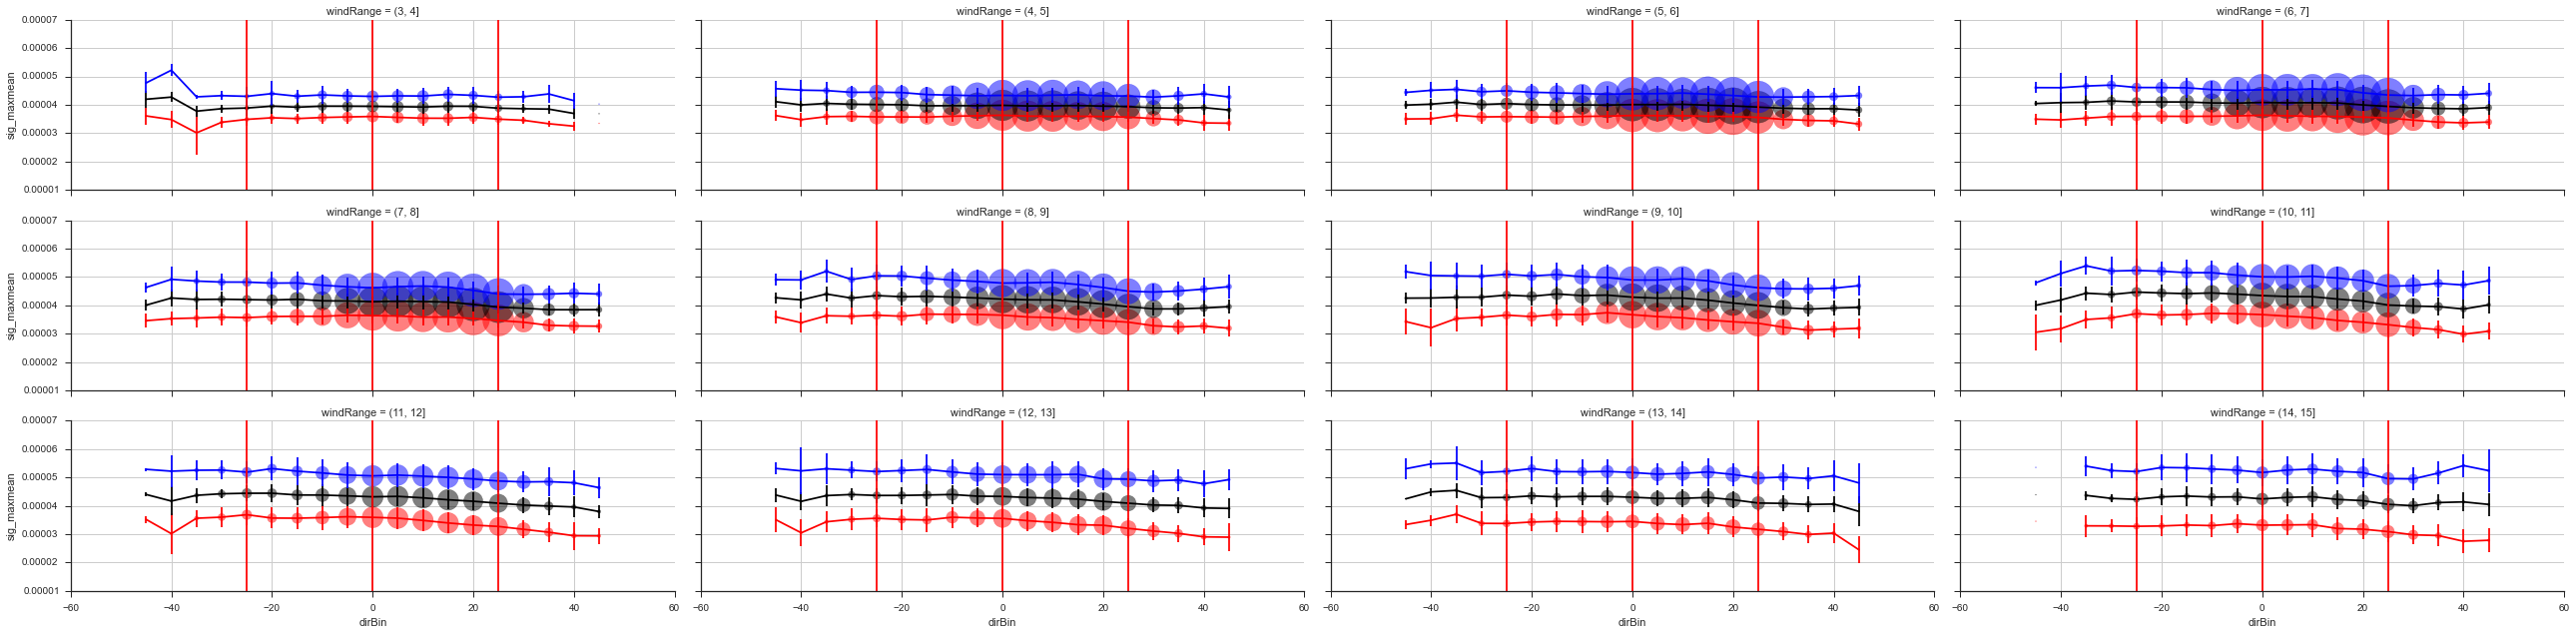

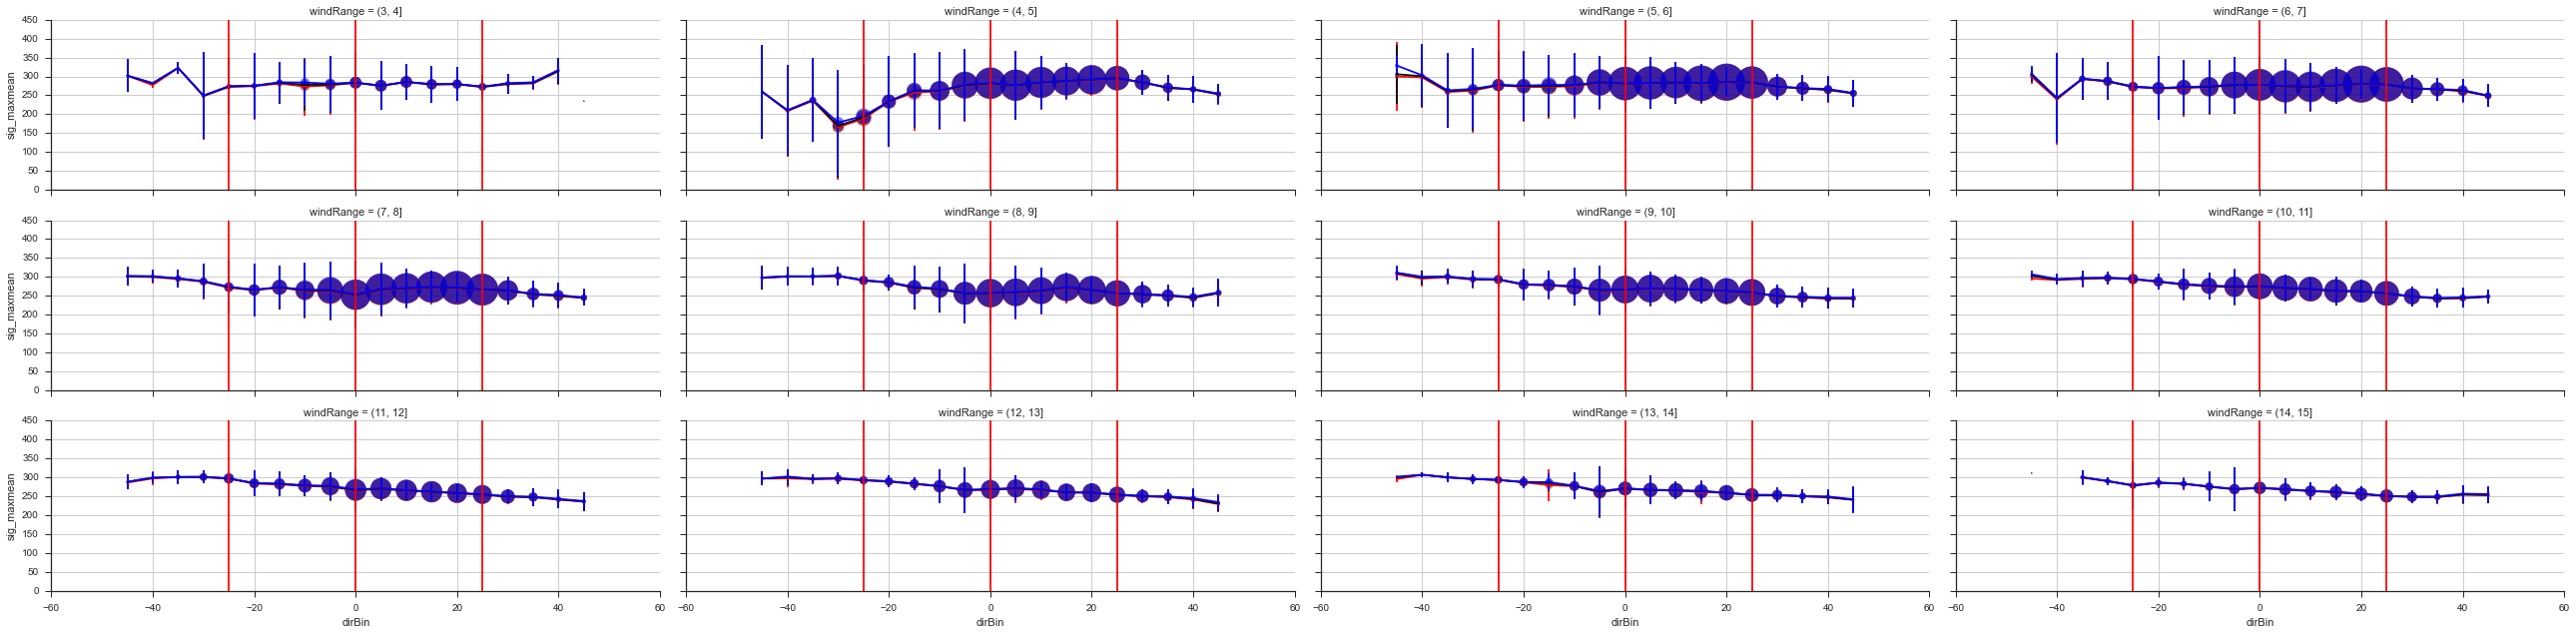

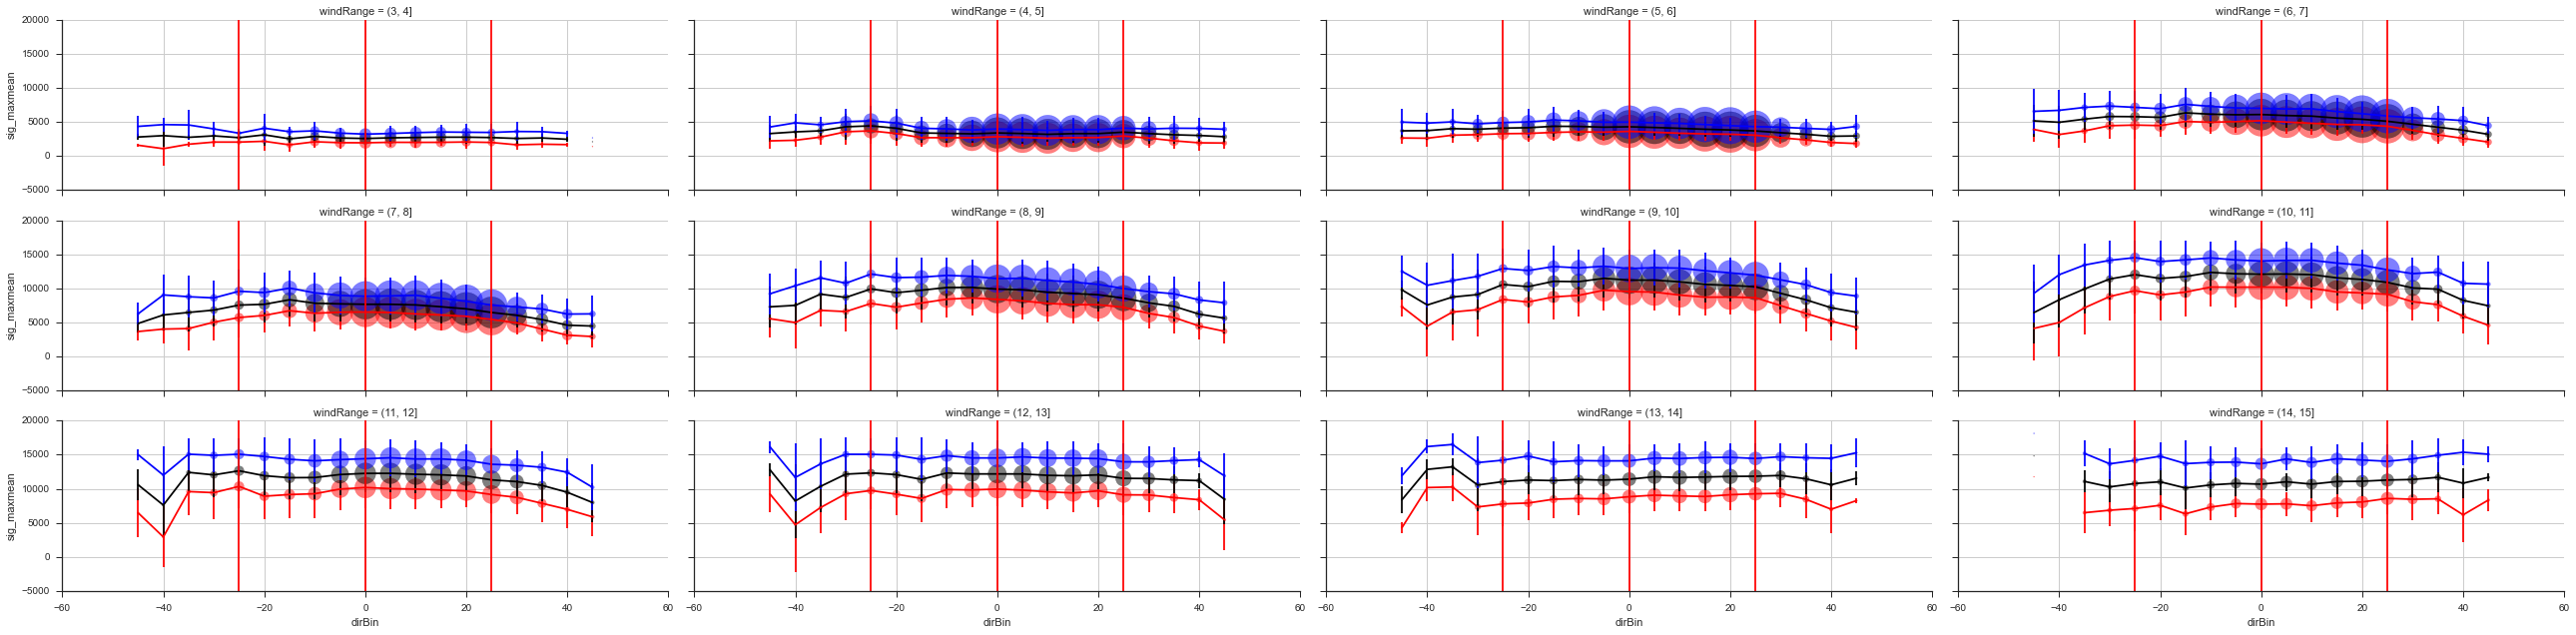

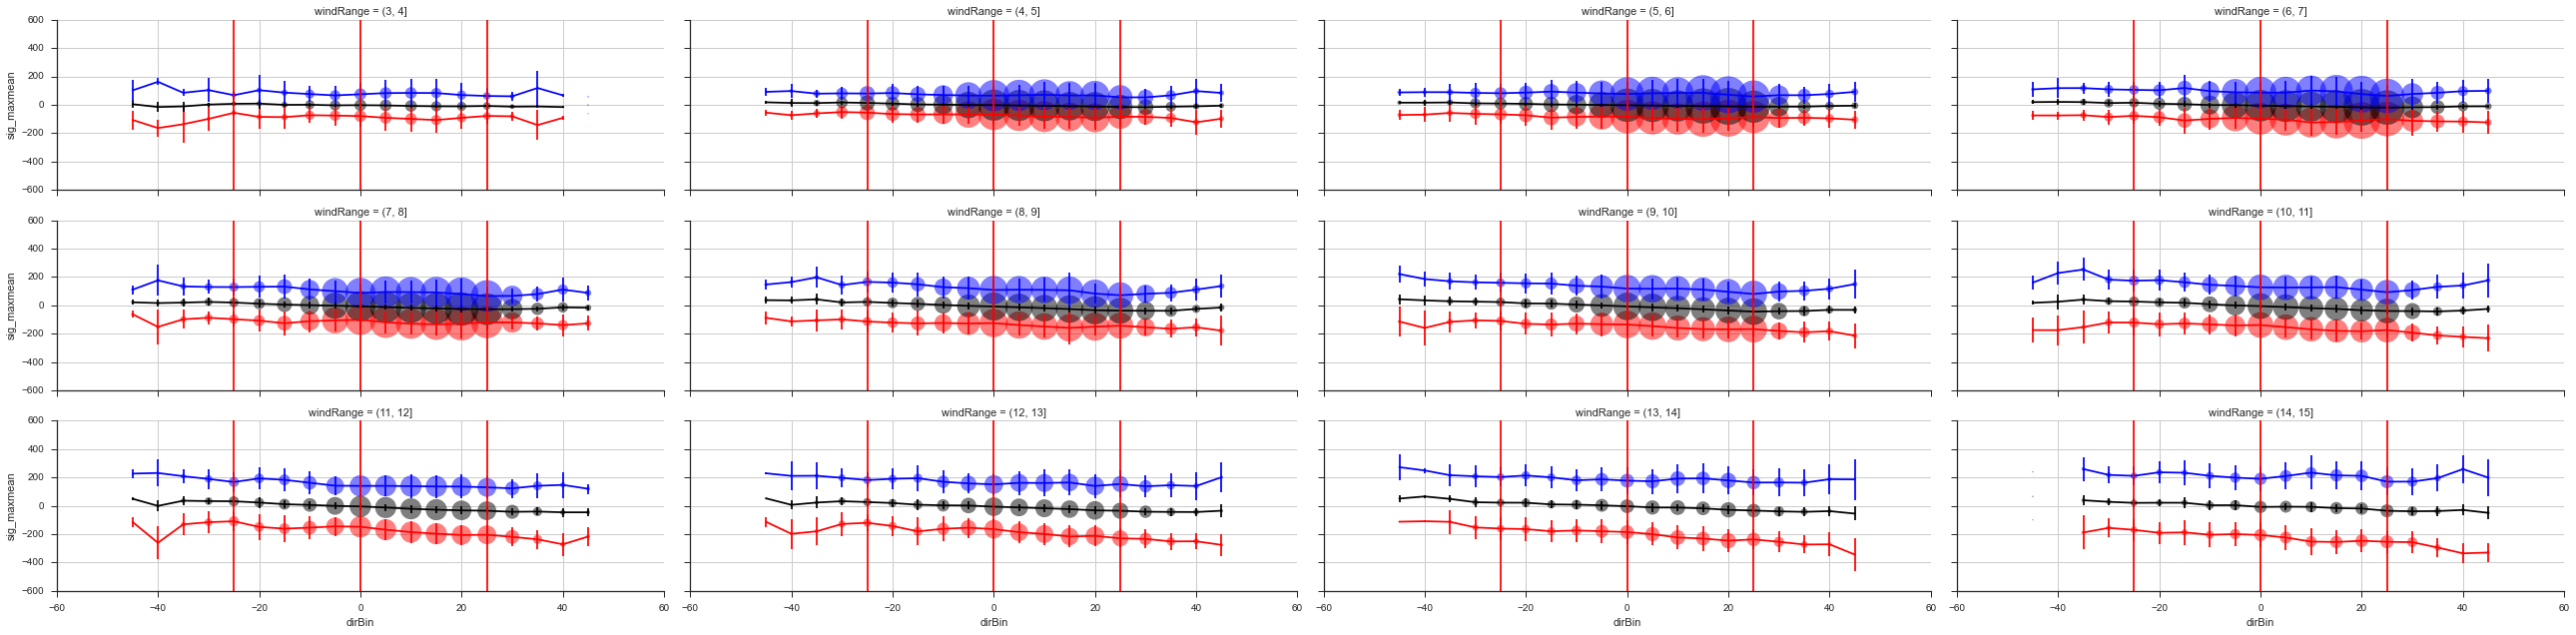

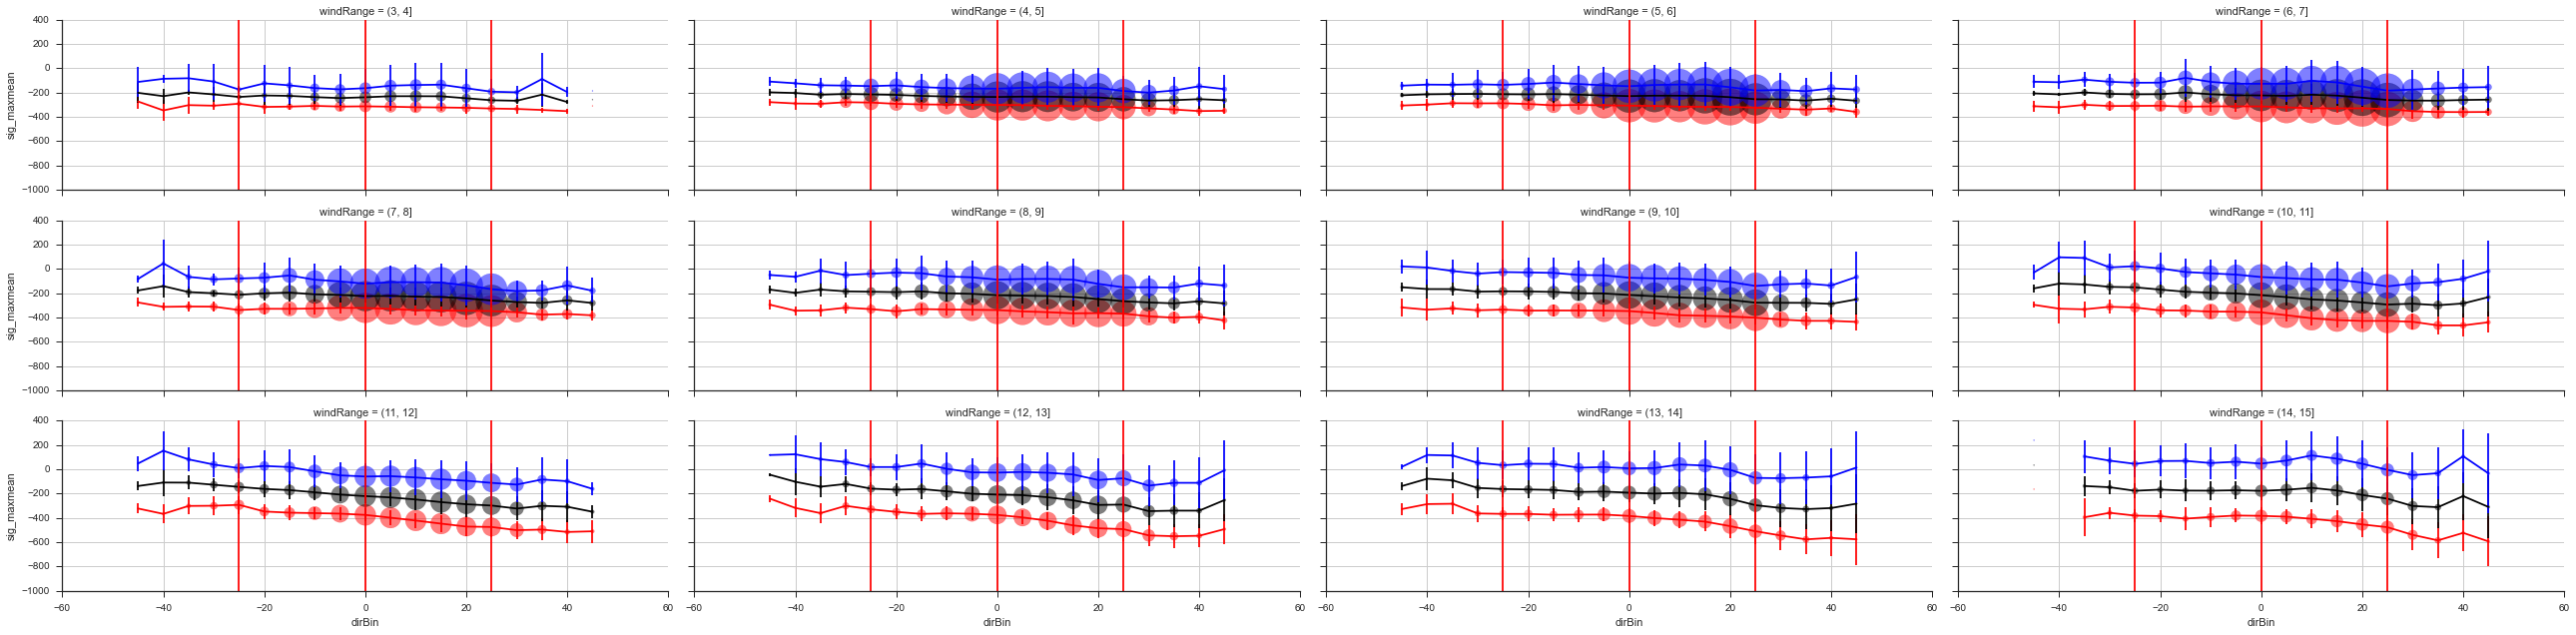

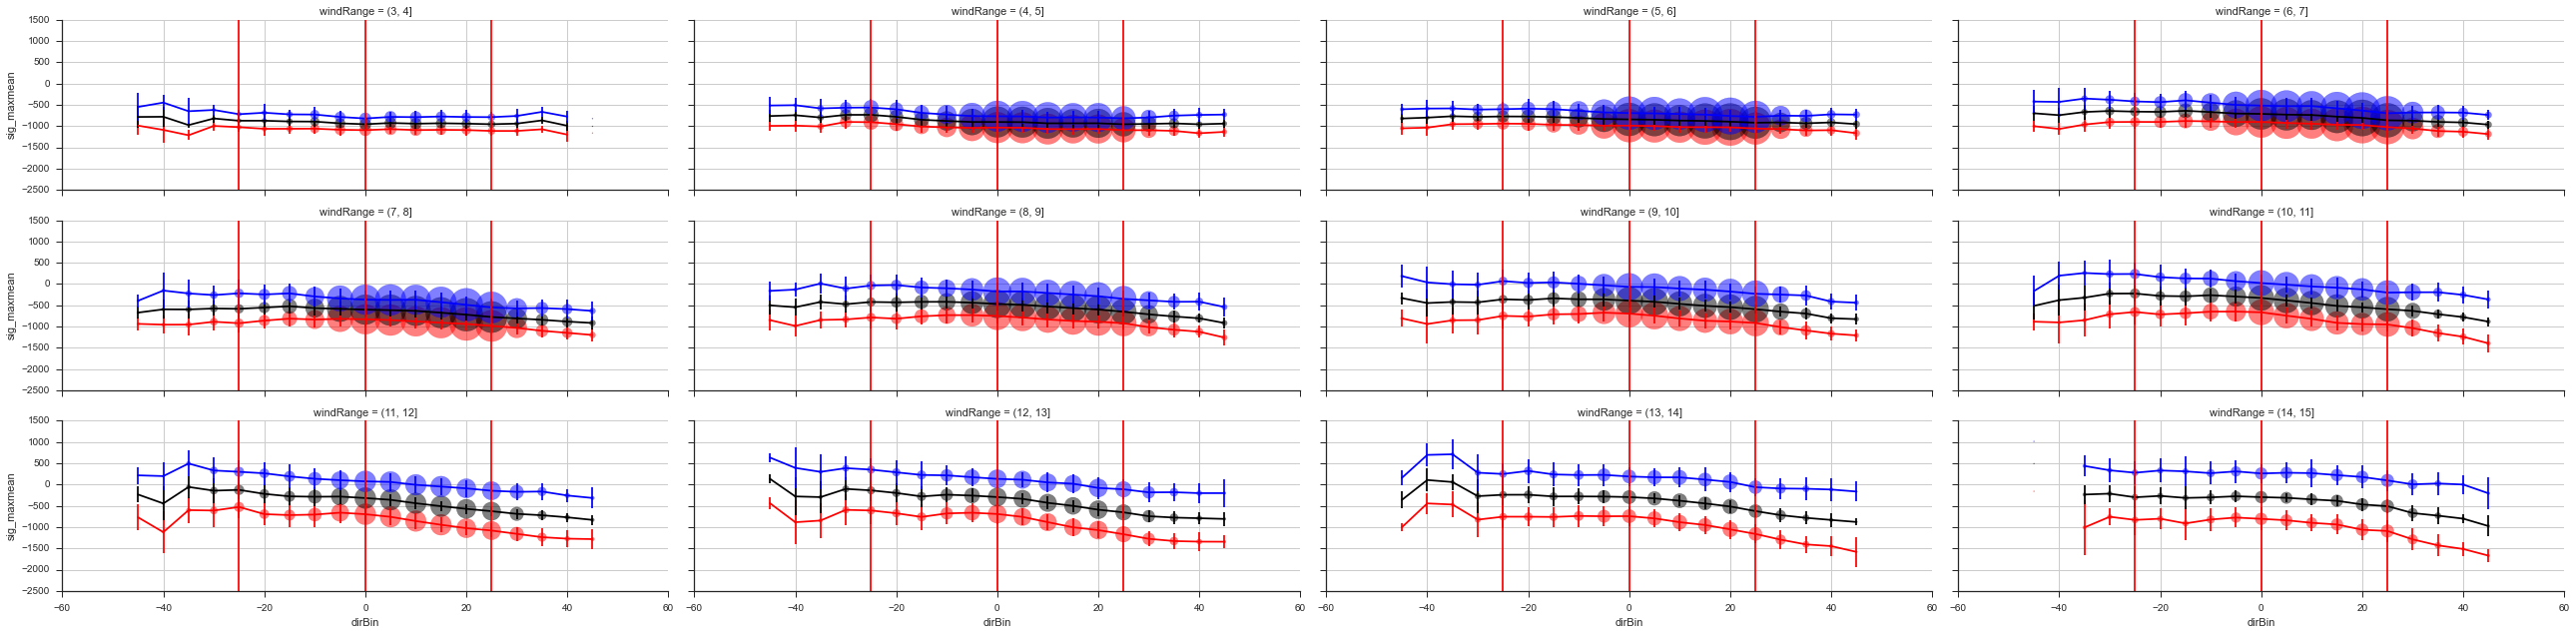

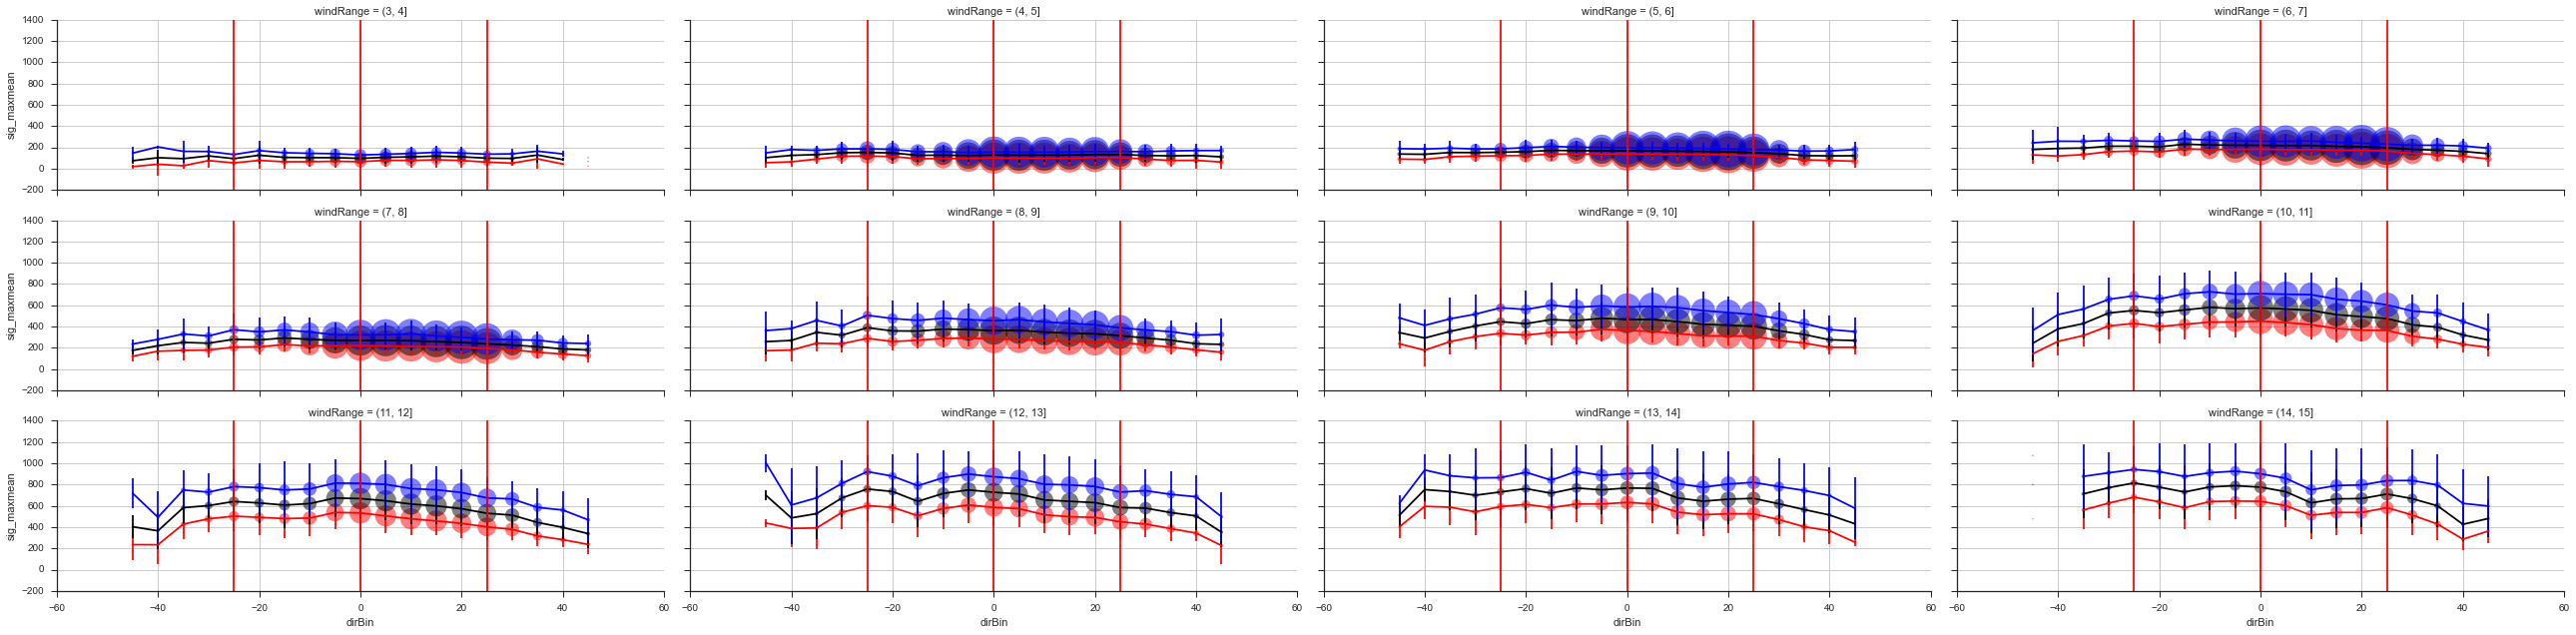

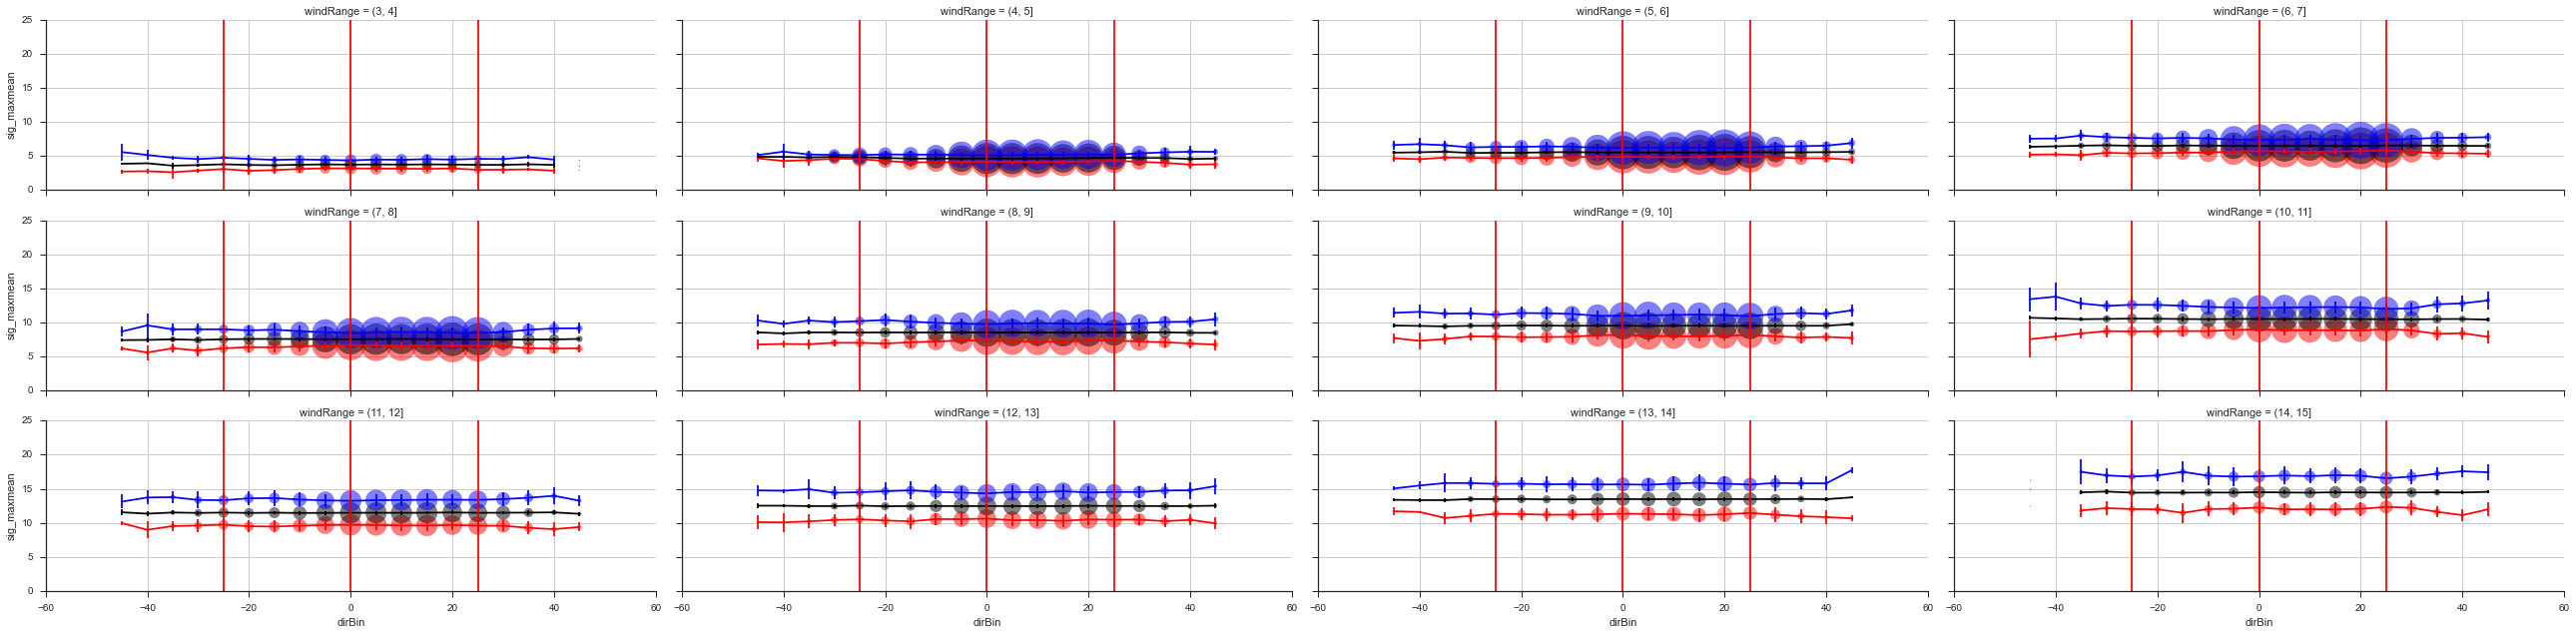

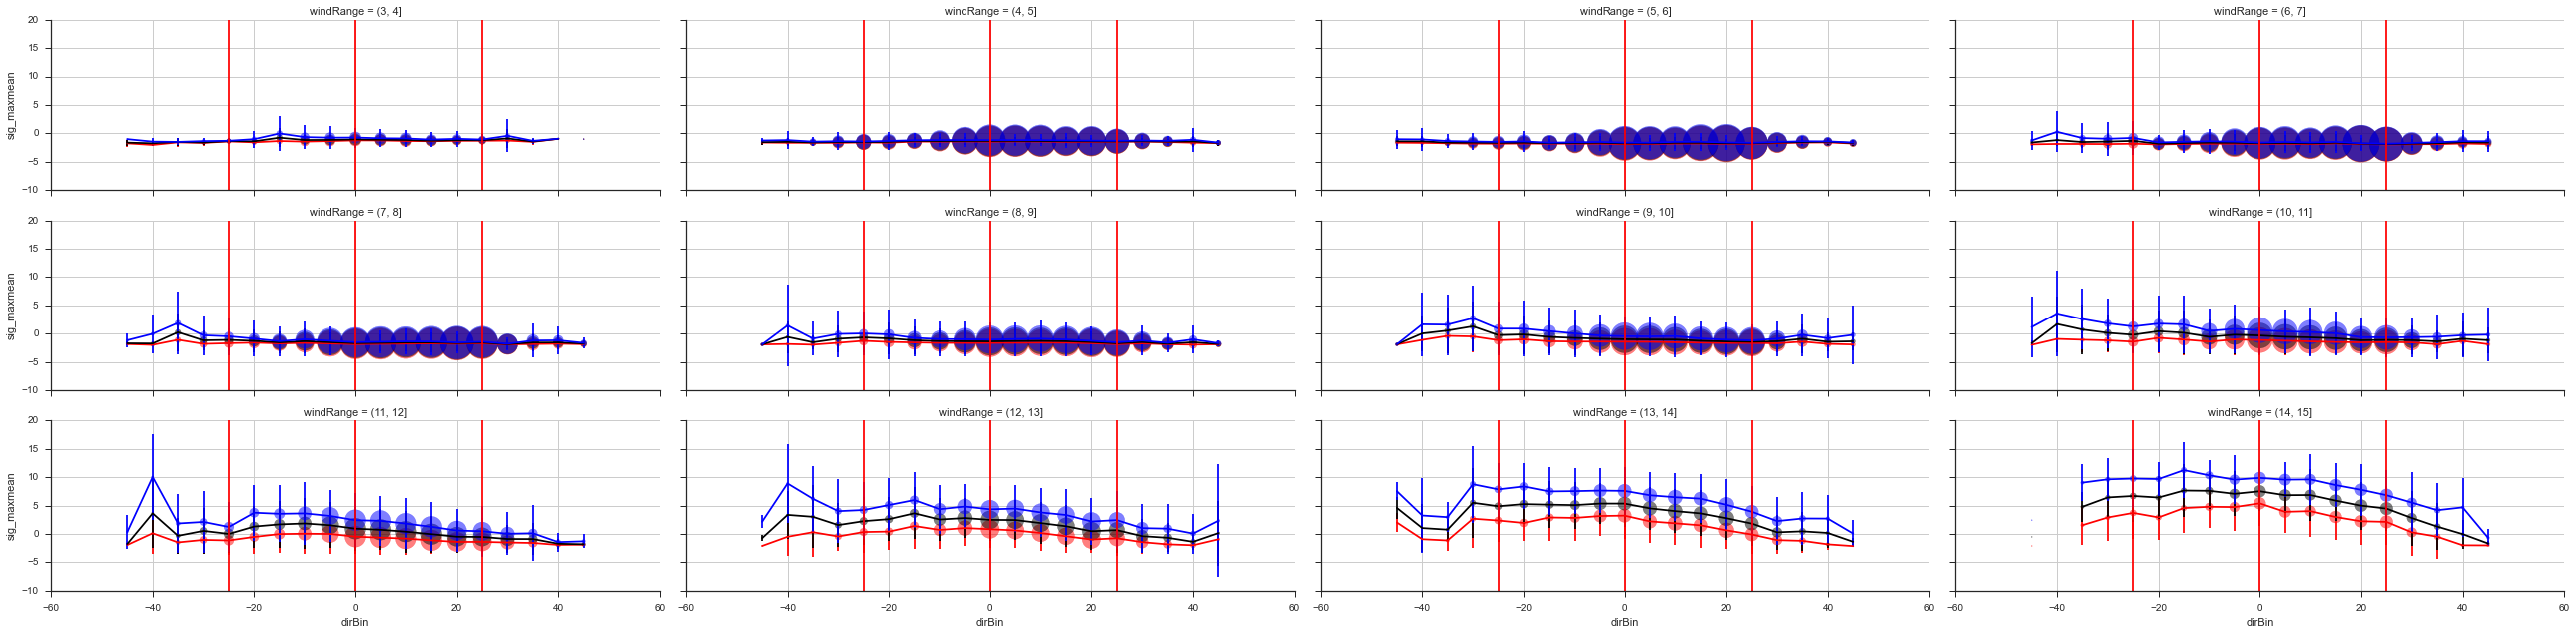

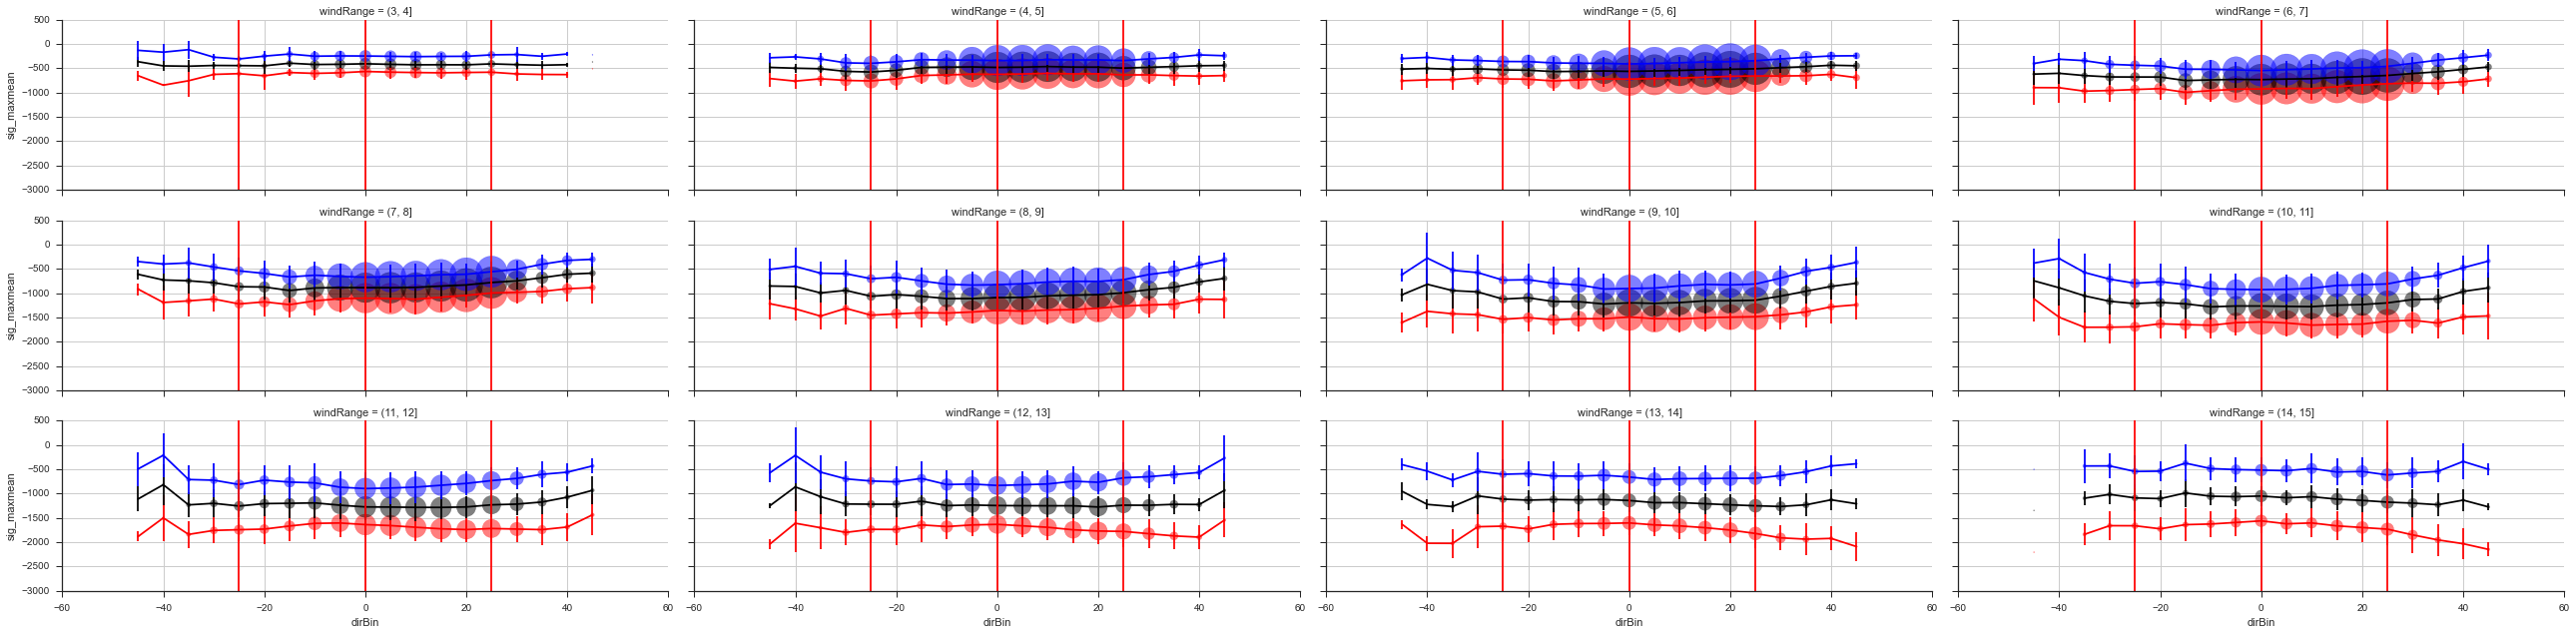

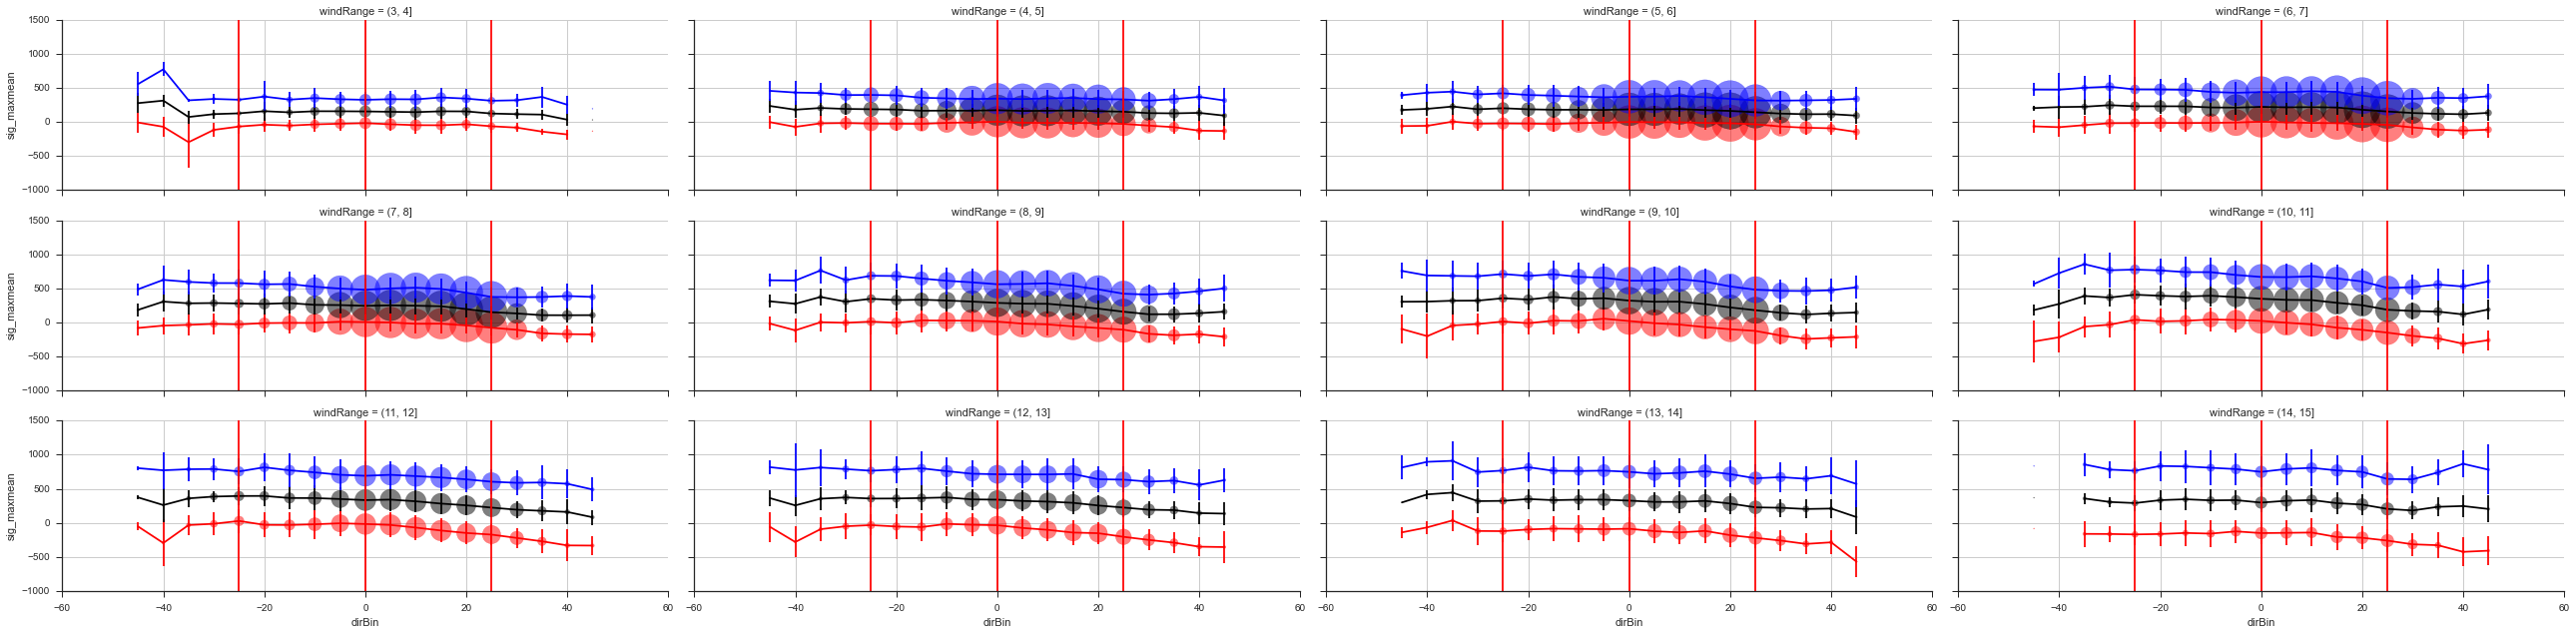

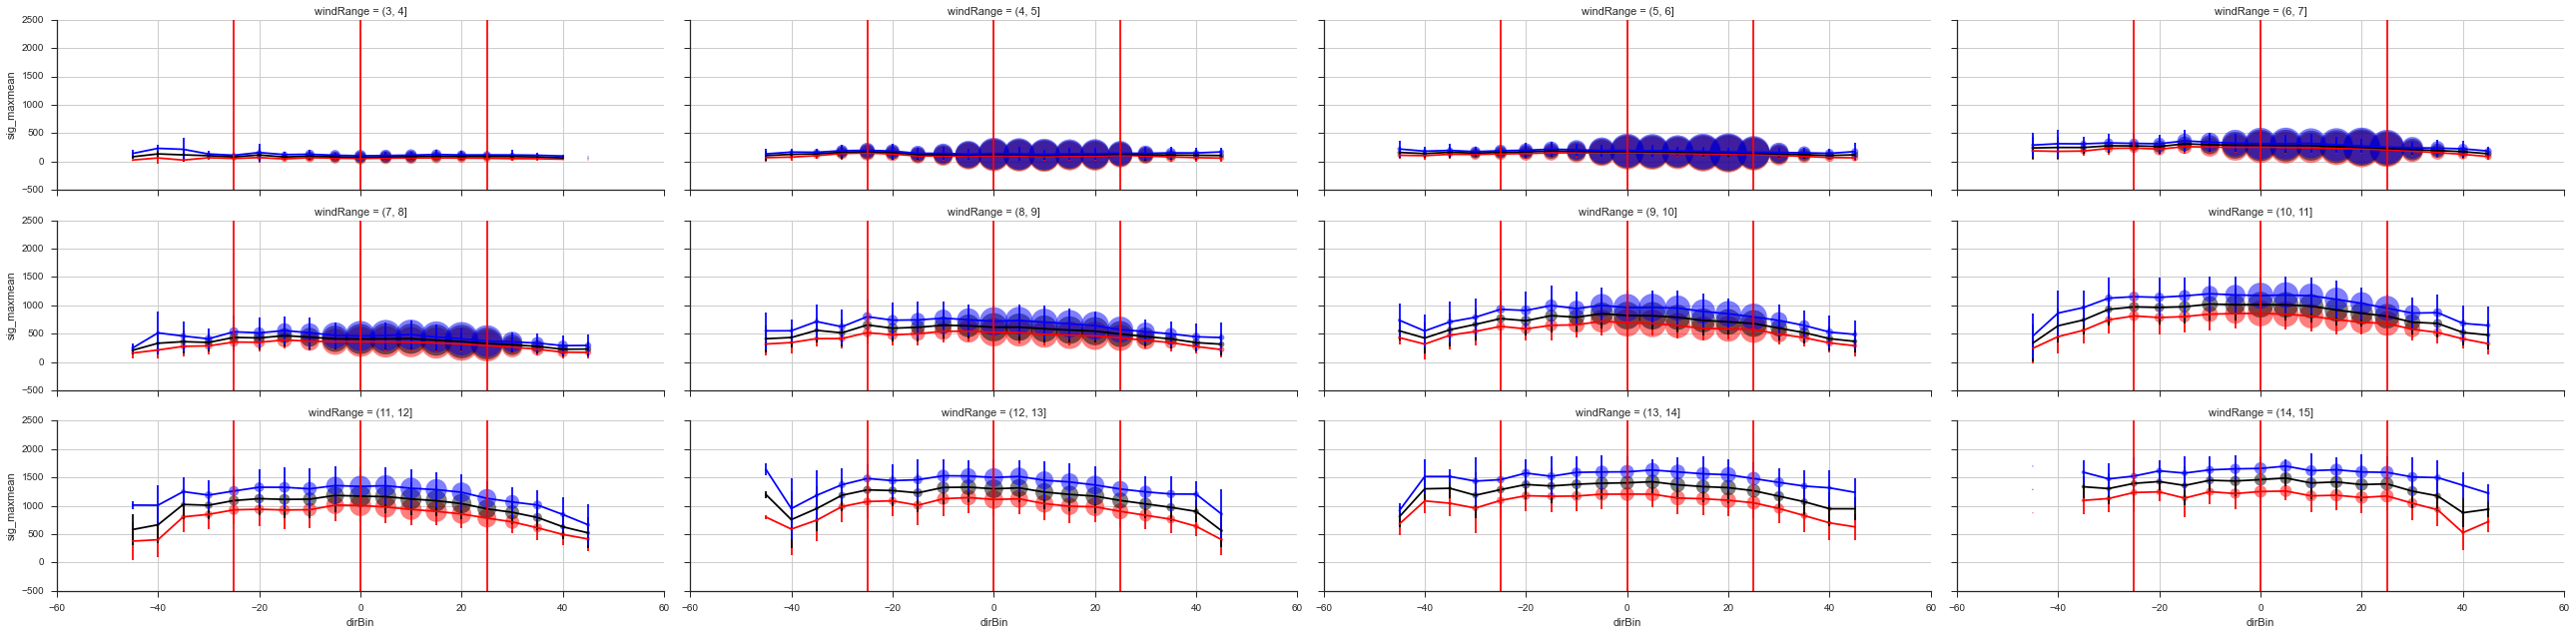

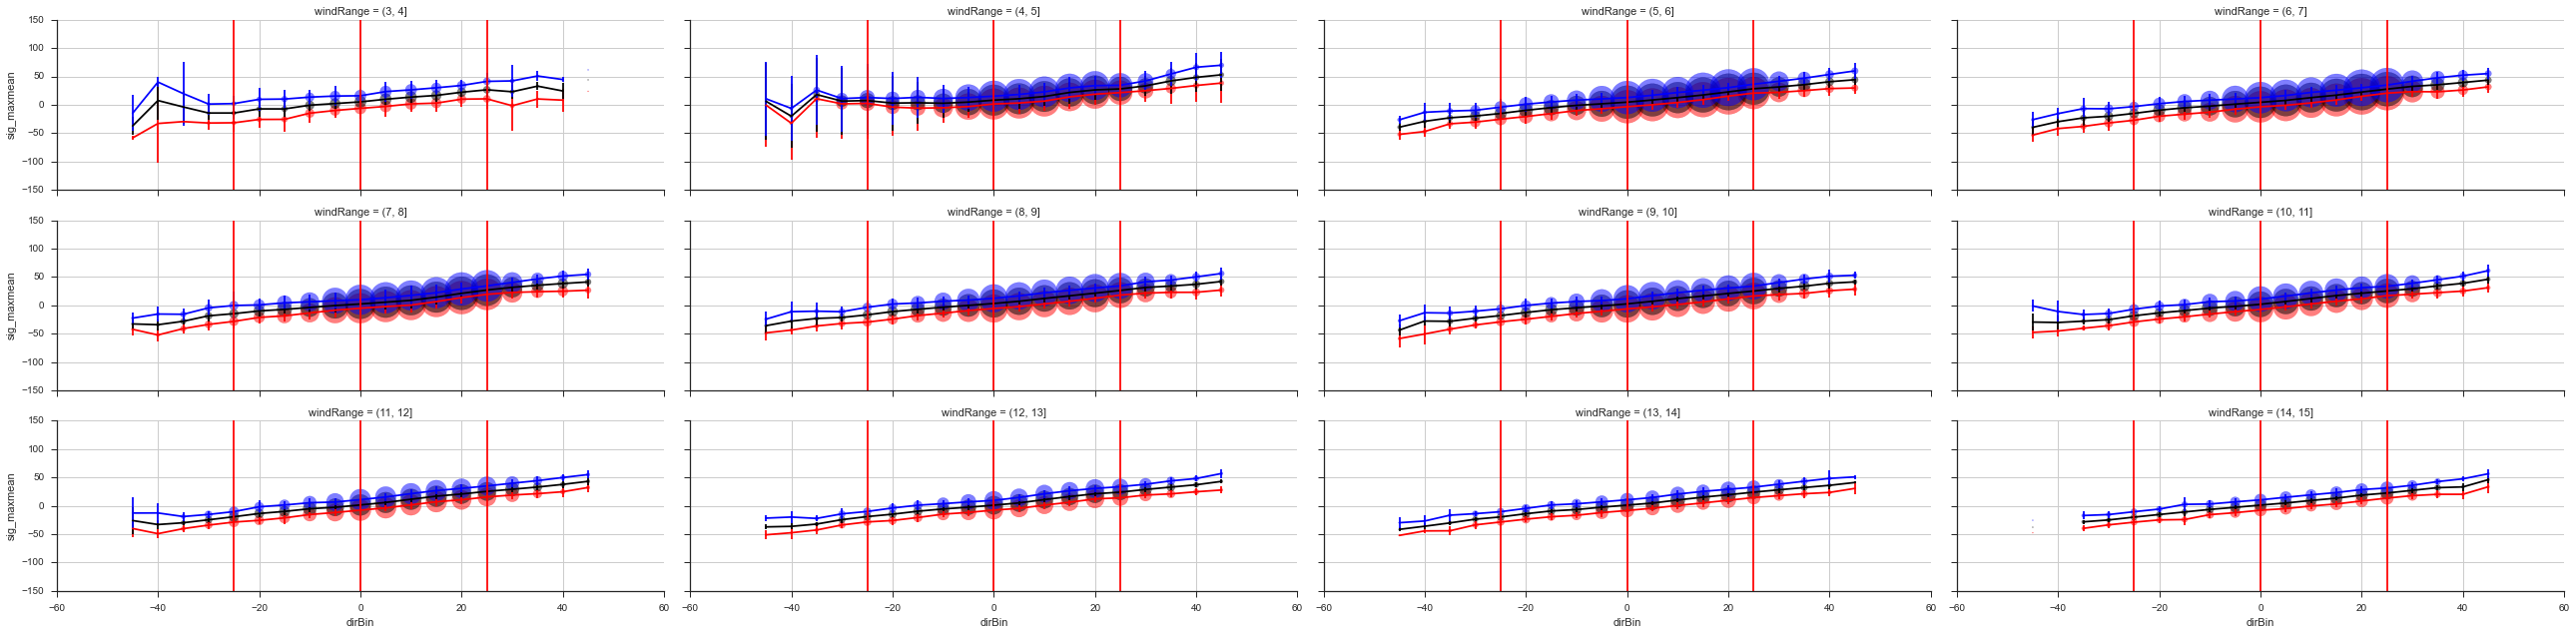

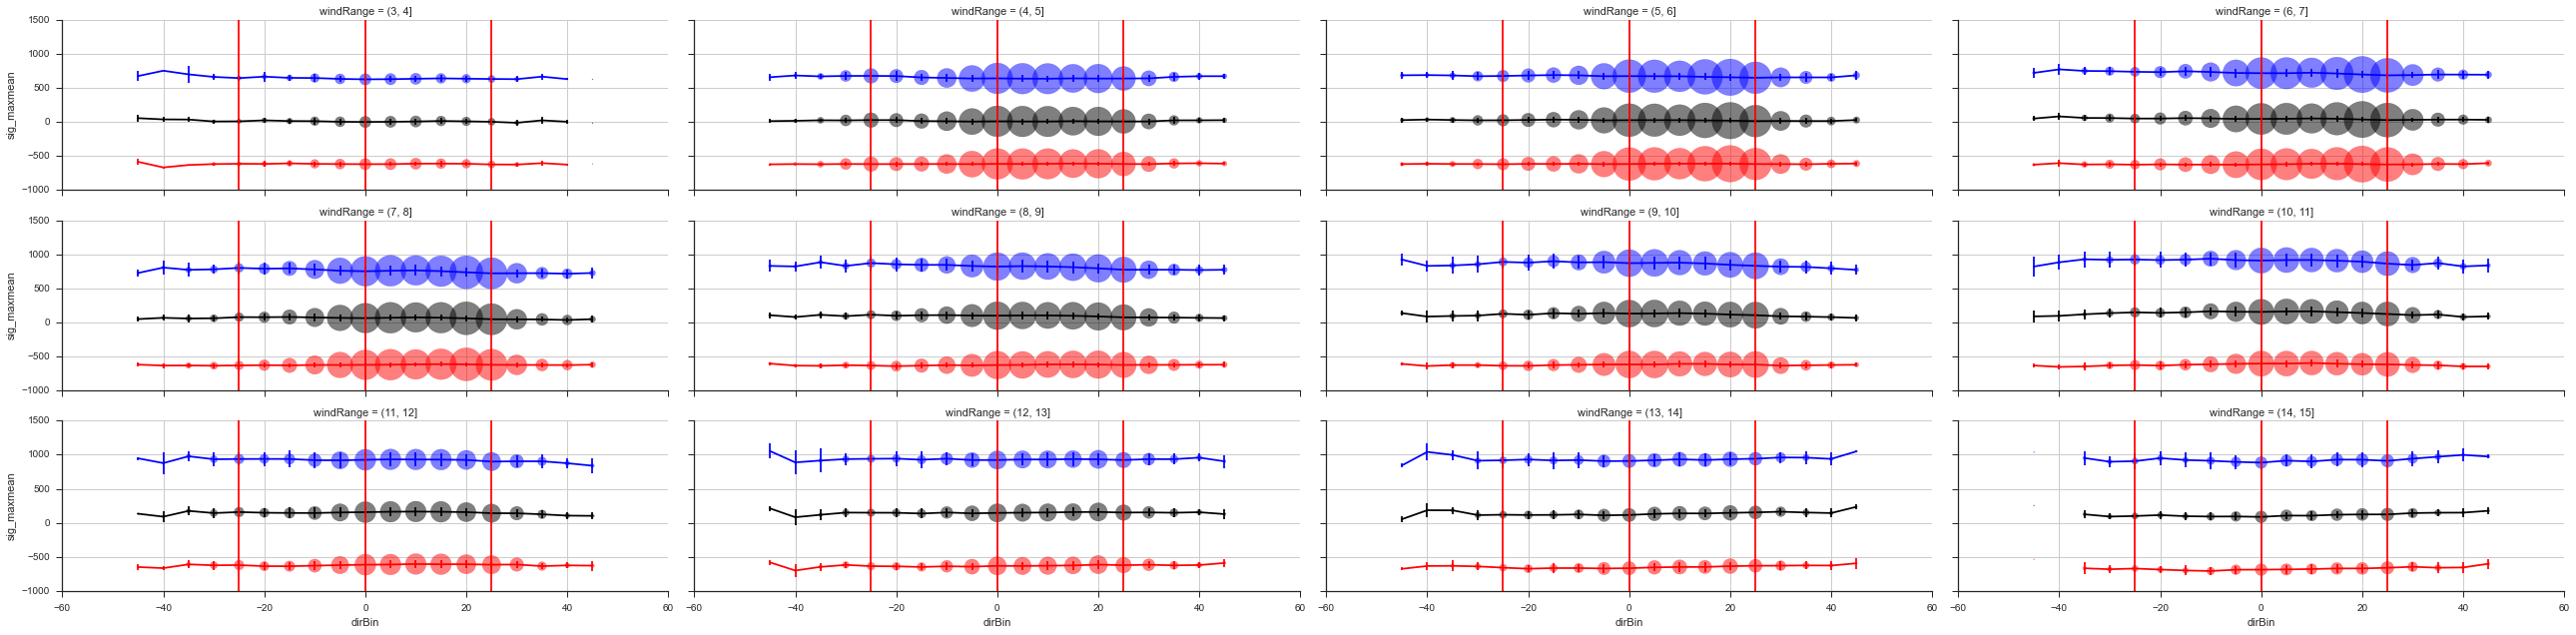

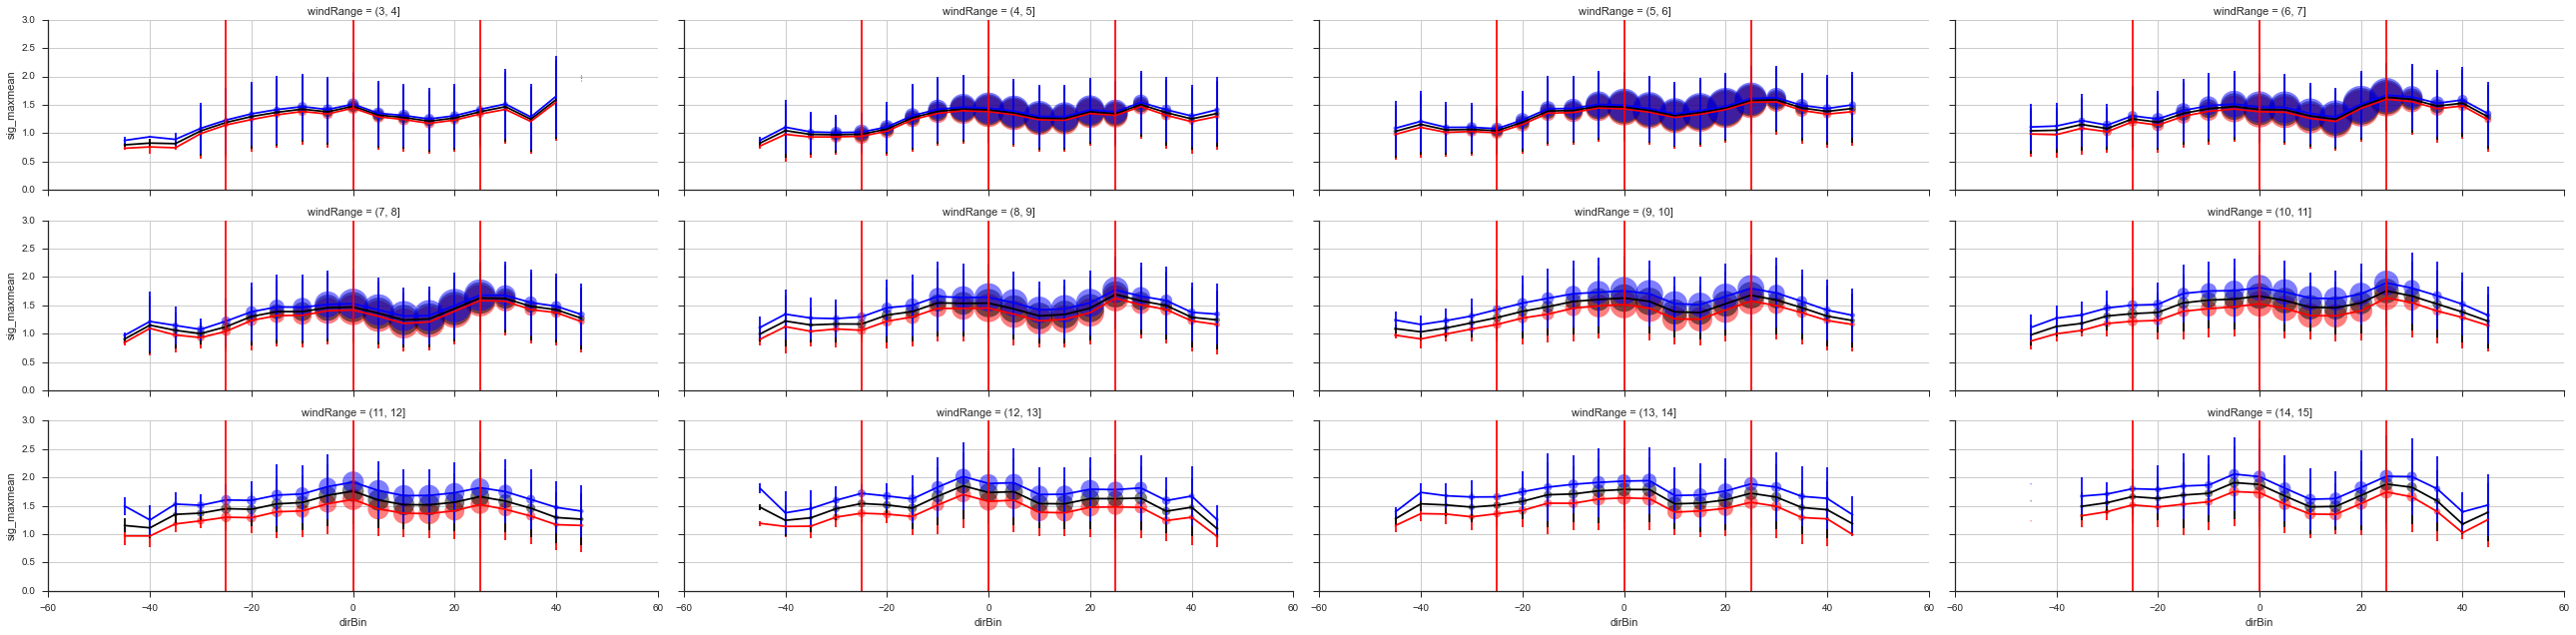

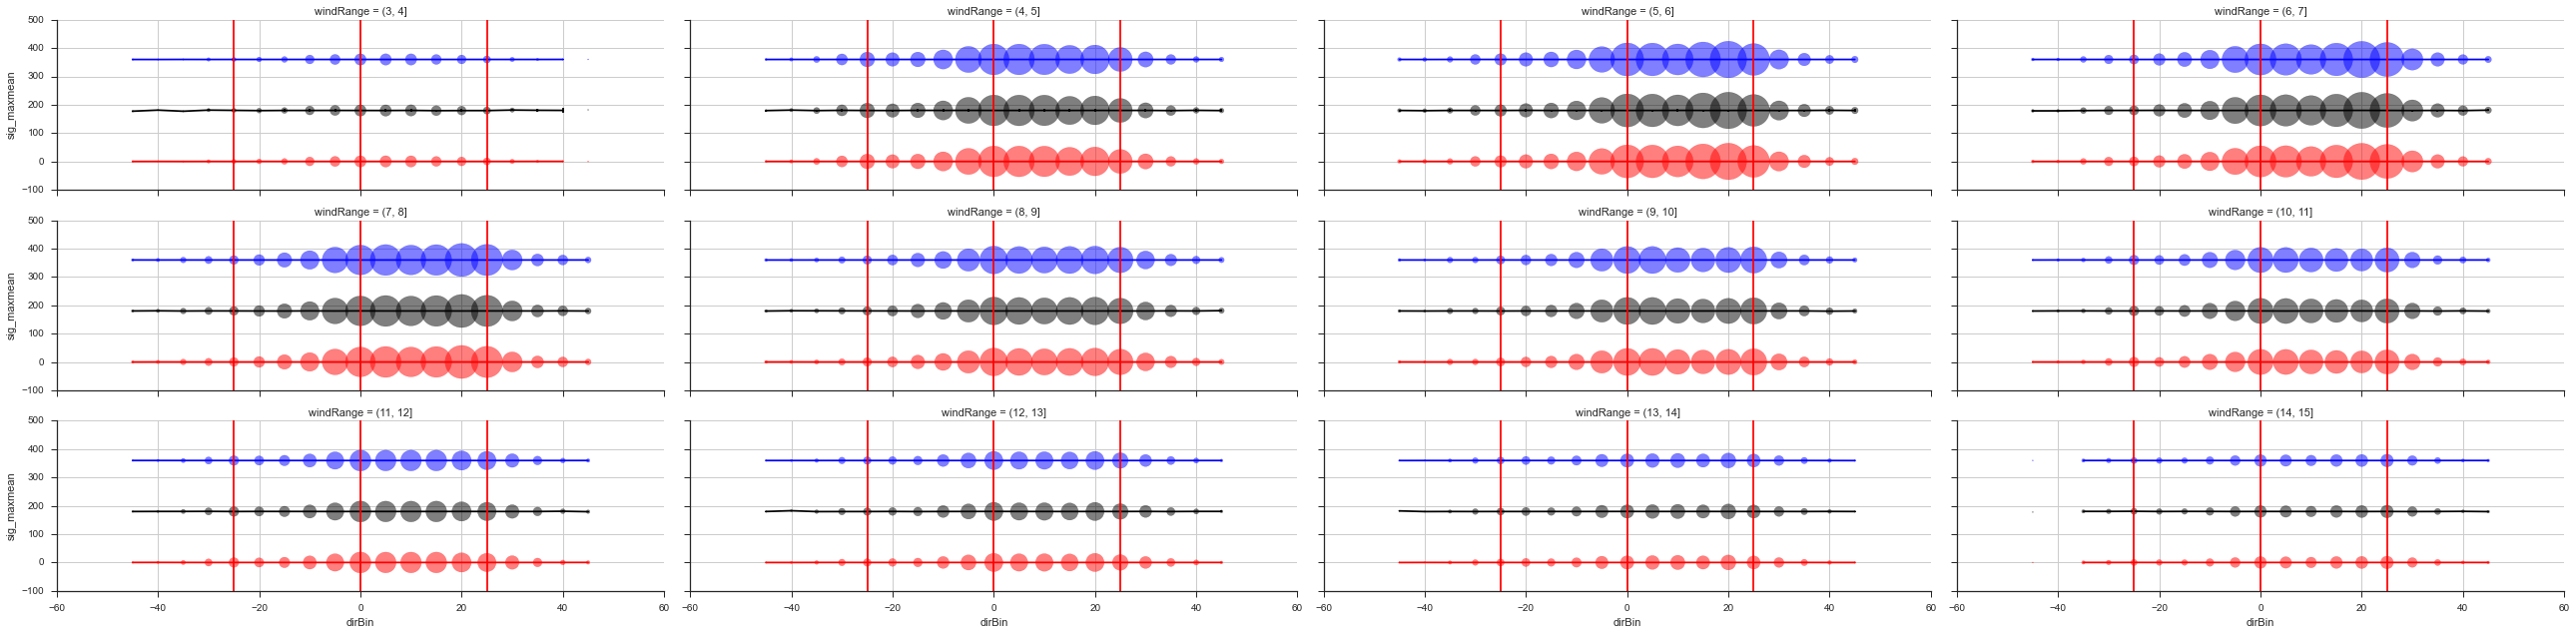

In [14]:
# Plot in a loop


for sig in rootNames:# [rootNames[2]]:
    
    if os.path.exists(os.path.join(maxminFolder,sig + '.png')):
        continue
    
    # Collect the statistics
    dataChannels = [ sig + '_min', sig + '_mean', sig + '_max']
    dfSub = dfGrouped[dataChannels].reset_index()
    dfSub.columns = [''.join(col).strip() for col in dfSub.columns.values]
    dfSub.columns = [c.replace(sig,'sig') for c in dfSub.columns]
    
    # Melt the data
    #dfMelt = pd.melt(dfSub,id_vars=['dirBin','windRange'])
    
    g = sns.FacetGrid(dfSub, col="windRange",col_wrap=4, aspect=3)#, ylim=(0, 10))
    g.map(plt.errorbar, "dirBin", "sig_minmean", "sig_minstd", capsize=4,c='r')
    g.map(plt.scatter, "dirBin", "sig_minmean", 'sig_mincount', color='r',alpha=0.5)
    
    g.map(plt.errorbar, "dirBin", "sig_meanmean", "sig_meanstd", capsize=4,c='k')
    g.map(plt.scatter, "dirBin", "sig_meanmean", 'sig_meancount', color='k',alpha=0.5)
    
    g.map(plt.errorbar, "dirBin", "sig_maxmean", "sig_maxstd", capsize=4,c='b')
    g.map(plt.scatter, "dirBin", "sig_maxmean", 'sig_maxcount', color='b',alpha=0.5)

    for ax in g.axes.flat:
        ax.axvline(-25,color='r')
        ax.axvline(0,color='r')
        ax.axvline(25,color='r')
        ax.grid()

    g.savefig(os.path.join(maxminFolder,sig + '.png'),dpi=150)